# Юнит 2. Разведывательный анализ данных

**Цель проекта:** 
Подготовить датасет к использованию его для построения модели.

**Задачи проекта:**
- Изучить данные, определить ошибки считывания, пропуски и выбросы.
- Выявить и исправить неправильную типизацию.
- Визуализировать данные о распределении категориальных и числовых непрерывных переменных.
- Заполнить пропуски, подготовить датасет к построению модели.
- Определить степень влияния признаков на целевую переменную, степень корреляции числовых непрерывных признаков. Попутно сделать выводы о закономерностях их взаимоотношения признаков между собой.
- Выявить данные значимые для построения рабочей модели

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

import seaborn as sns

from itertools import combinations

from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # выведем больше строк

pd.set_option('display.max_columns', 50) # выведем больше колонок

df=pd.read_csv('raw\\stud_math.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

В датасете 395 строк, 30 столбцов. Во всех столбцах, кроме первых трёх - school, sex, age - есть пропуски. 

In [2]:
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [2]:
#Для cобственного удобства определяю функцию, которая делают yes/no булевыми, 
def yn_to_bool(x):
    if x == 'yes':
        return True
    elif x == 'no':
        return False
    else: return x

Напишем несколько функций филлеров (отдельно для категориальных и непрерывных переменных), с помощью которых в дальнейшем будем заполнять пропуски в данных.

In [3]:
def filler(row):
    train = df[df[c].notna()] # тренировочный датасет, где все значения искомой переменной заполнены
    if pd.isnull(row[c]):
        for chars in c_list:
            train=train[train[chars] == row[chars]]
        if len(train[c].value_counts())>0:
            return train[c].value_counts().index[0]
        else: return row[c]
    return row[c]

def absence_filler(row):
    train = df[df.absences.notna()]
    if pd.isnull(row.absences):
        for chars in c_list:
            train=train[train[chars] == row[chars]]
        if len(train.absences.value_counts())>0:
            return train.absences.median()
        else: return row.absences
    return row.absences

def score_filler(row):
    train = df[df.score.notna()]
    if pd.isnull(row.score):
        for chars in c_list:
            train=train[train[chars] == row[chars]]
        if len(train.score.value_counts())>0:
            return train.score.median()
        else: return row.score
    return row.score

*Часть признаков являются числовыми по типу данных, но категориальными по своей сути (категории 1,2,3,4). Оставлю их числовыми, т.к. категории названы в порядке возрастания признака который они кодируют, и возможно пригодится возможность сравнивать их (< >)*

In [4]:
#Для удобства превратим yes/no в булевые
df.schoolsup = df.schoolsup.apply(lambda x: yn_to_bool(x))
df.famsup = df.famsup.apply(lambda x: yn_to_bool(x))
df.paid = df.paid.apply(lambda x: yn_to_bool(x))
df.activities = df.activities.apply(lambda x: yn_to_bool(x))
df.nursery = df.nursery.apply(lambda x: yn_to_bool(x))
df.higher = df.higher.apply(lambda x: yn_to_bool(x))
df.internet = df.internet.apply(lambda x: yn_to_bool(x))
df.romantic = df.romantic.apply(lambda x: yn_to_bool(x))

# Univariate analysis

Оценим распределение категориальных и непрырывных признаков. Определим объем пропущенных данных. 

,school
GP,0.883544
MS,0.116456


Пропущено 0 значений


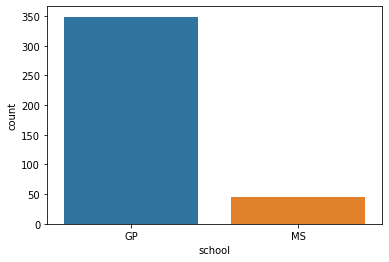

In [5]:
display(pd.DataFrame(df.school.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.school.isnull().sum()))
sns.countplot(df.school)

In [5]:
df_ms = df[df.school == 'MS']
df_gp = df[df.school == 'GP']

In [7]:
print('В школе GP учится {} учеников, а в школе MS {} учеников'.format(len(df_gp),len(df_ms)))

В школе GP учится 349 учеников, а в школе MS 46 учеников


Можно сделать вывод, что в школе GP обучается больше учеников. Возможно она просто больше, возможно у нее лучше репутация, либо наоборот MS более элитарная и закрытая, на это стоит обратить внимание в дальнейшем.

,sex
F,0.526582
M,0.473418


Пропущено 0 значений


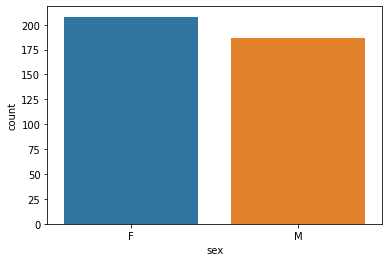

In [8]:
display(pd.DataFrame(df.sex.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.sex.isnull().sum()))
sns.countplot(df.sex)

In [9]:
df_gp.sex.value_counts(normalize = True)

F    0.524355
M    0.475645
Name: sex, dtype: float64

In [10]:
df_ms.sex.value_counts(normalize = True)

F    0.543478
M    0.456522
Name: sex, dtype: float64

Гендерный состав в обеих школах примерно 50/50

,age
16,0.263291
17,0.248101
18,0.207595
15,0.207595
19,0.060759
20,0.007595
22,0.002532
21,0.002532


Пропущено 0 значений


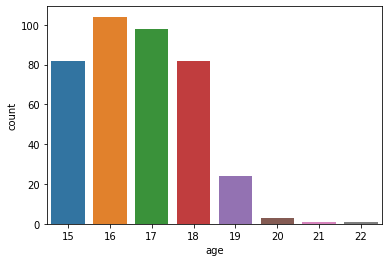

In [11]:
display(pd.DataFrame(df.age.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.age.isnull().sum()))
sns.countplot(df.age)

Всего 5 человек старше 19 лет. 20 лет - 3, 21 - 1, 22 - 1.

,address
U,0.780423
R,0.219577


Пропущено 17 значений


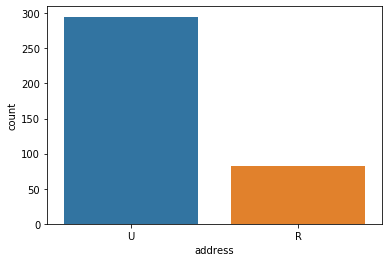

In [12]:
display(pd.DataFrame(df.address.value_counts(normalize=True)))
print('Пропущено {} значений'.format(df.address.isnull().sum()))
sns.countplot(df.address)

Большинство учеников живут в черте города

In [13]:
display(df_gp.traveltime.value_counts(normalize=True))

1.0    0.704615
2.0    0.233846
3.0    0.043077
4.0    0.018462
Name: traveltime, dtype: float64

In [14]:
df_gp[df_gp.traveltime > 2].address.value_counts(normalize = True)

U    0.6
R    0.4
Name: address, dtype: float64

In [15]:
df_gp[df_gp.traveltime <= 2].address.value_counts(normalize = True)
#большинство учеников, которым недалеко добираться до школы - живут в городе

U    0.840678
R    0.159322
Name: address, dtype: float64

In [16]:
display(df_ms.traveltime.value_counts(normalize=True))

2.0    0.476190
1.0    0.309524
3.0    0.190476
4.0    0.023810
Name: traveltime, dtype: float64

In [9]:
df_ms[df_ms.traveltime > 2].address.value_counts()
# мы видим, что фактически все ученики школы MS, которым долго добираться до школы, живут за чертой города,

R    8
Name: address, dtype: int64

In [18]:
df_ms[df_ms.traveltime <= 2].address.value_counts(normalize = True)
#ученики которым не так долго добираться до школы живут и в черте и за чертой города.

U    0.566667
R    0.433333
Name: address, dtype: float64

In [19]:
# Размер семьи. >3 и <=3 членов соответственно.
display(pd.DataFrame(df.famsize.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.famsize.isnull().sum()))

,famsize
GT3,0.709239
LE3,0.290761


Пропущено 27 значений


In [21]:
# Родители живут вместе или раздельно
display(pd.DataFrame(df.Pstatus.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.Pstatus.isnull().sum()))

,Pstatus
T,0.897143
A,0.102857


Пропущено 45 значений


In [22]:
df[df.Pstatus == "T"].famsize.value_counts(normalize = True)

GT3    0.72449
LE3    0.27551
Name: famsize, dtype: float64

In [10]:
df[df.Pstatus == "A"].famsize.value_counts(normalize = True)

GT3    0.606061
LE3    0.393939
Name: famsize, dtype: float64

Среди семей, где родители живут отдельно выше процент маленьких семей.

,Medu
4.0,0.334184
2.0,0.260204
3.0,0.247449
1.0,0.150510
0.0,0.007653


Пропущено 3 значений


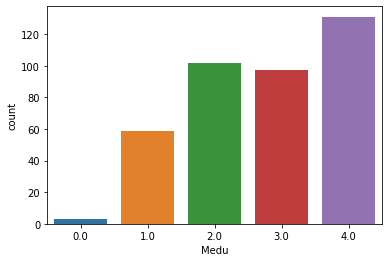

In [11]:
# Образование матери
display(pd.DataFrame(df.Medu.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.Medu.isnull().sum()))
sns.countplot(df.Medu)

In [12]:
# Образование отца
display(pd.DataFrame(df.Fedu.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.Fedu.isnull().sum()))
#видим выброс - 40, скорее всего опечатка и имеется в виду 4

,Fedu
2.0,0.285714
3.0,0.258760
4.0,0.237197
1.0,0.210243
0.0,0.005391
40.0,0.002695


Пропущено 24 значений


In [6]:
df.loc[df.Fedu == 40.0, 'Fedu'] = 4 #исправим опечатку

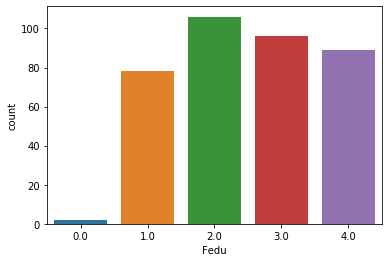

In [6]:
sns.countplot(df.Fedu)

,Mjob
other,0.353723
services,0.260638
at_home,0.154255
teacher,0.146277
health,0.085106


Пропущено 19 значений


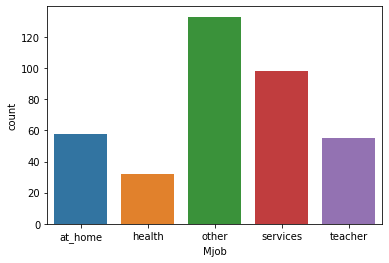

In [20]:
# Cфера в которой работает мать
display(pd.DataFrame(df.Mjob.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.Mjob.isnull().sum()))
sns.countplot(df.Mjob)

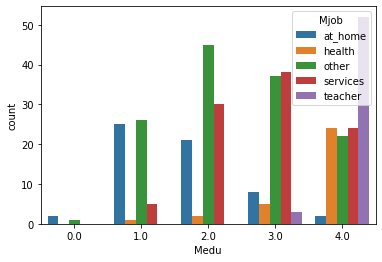

In [16]:
sns.countplot(x="Medu", hue = "Mjob", data=df)
#мы видим, что чем выше образование, тем больше учителей и врачей среди матерей, почти у всех учителей высшее образование

,Fjob
other,0.548747
services,0.284123
teacher,0.080780
at_home,0.044568
health,0.041783


Пропущено 36 значений


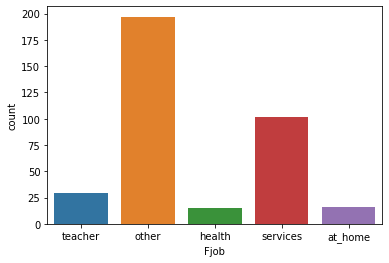

In [21]:
#Сфера в которой работает отец
display(pd.DataFrame(df.Fjob.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.Fjob.isnull().sum()))
sns.countplot(df.Fjob)

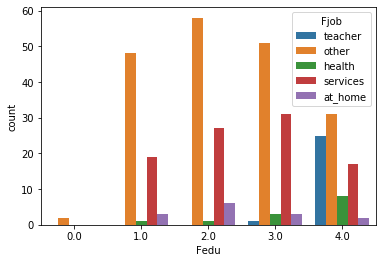

In [7]:
sns.countplot(x="Fedu", hue = "Fjob", data=df)

Родители в этой выборке относительно редко оказываются учителями, преобладают категории other и services, но матери куда чаще учителя и врачи (достаточно интеллектуальные профессии).
Факт наличия родителей учителей может влиять на оценку, равно как и наличие родителей с образованием / высшим образованием. Среди родителей с высшим образованием большая доля - учителя и врачи, как среди матерей, так и среди отцов.

,reason
course,0.362434
home,0.275132
reputation,0.272487
other,0.089947


Пропущено 17 значений
course        18
home          10
other          9
reputation     5
Name: reason, dtype: int64


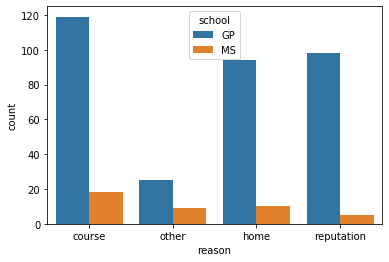

In [103]:
#Причина выбора школы
display(pd.DataFrame(df.reason.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.reason.isnull().sum()))
sns.countplot(x="reason", hue = "school", data=df)

Видно, что существенное количество учеников школы 'GP' выбрали ее из-за репутации. а в школе 'MS' этот критерий на последнем месте.

,guardian
mother,0.686813
father,0.236264
other,0.076923


Пропущено 31 значений


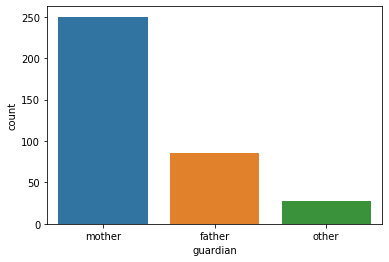

In [104]:
display(pd.DataFrame(df.guardian.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.guardian.isnull().sum()))
sns.countplot(df.guardian)

,traveltime
1.0,0.659401
2.0,0.261580
3.0,0.059946
4.0,0.019074


Пропущено 28 значений


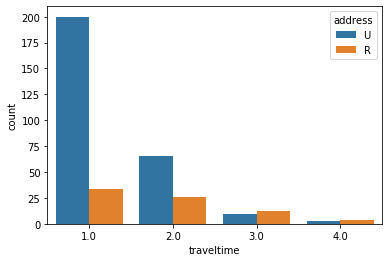

In [116]:
#Время которое ученики тратят, чтобы добраться до школы
display(pd.DataFrame(df.traveltime.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.traveltime.isnull().sum()))
sns.countplot(x="traveltime", hue = "address", data=df)

Cреди школьников, которым добираться дольше получаса больше человек, живущих за чертой города.

,studytime
2.0,0.500000
1.0,0.265464
3.0,0.164948
4.0,0.069588


Пропущено 7 значений


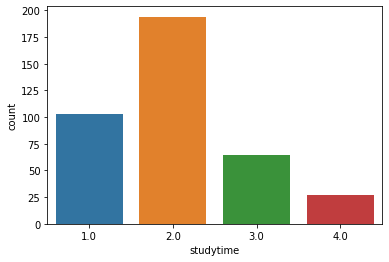

In [25]:
#время, затрачиваемое на учебу
display(pd.DataFrame(df.studytime.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.studytime.isnull().sum()))
sns.countplot(df.studytime)

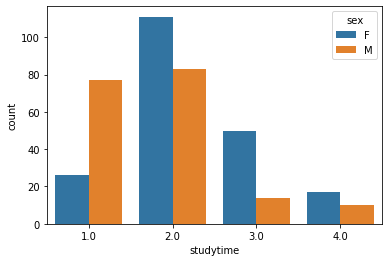

In [118]:
sns.countplot(x="studytime", hue = "sex", data=df)

Заметно, что в категориях 3 и 4 куда больше девушек чем парней. 

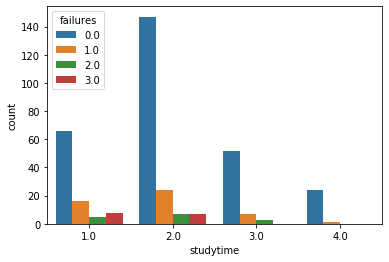

In [120]:
sns.countplot(x="studytime", hue = "failures", data=df)

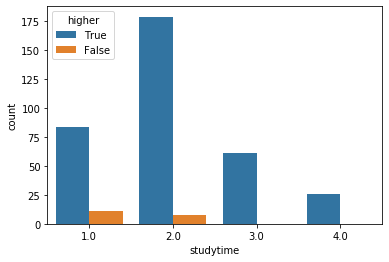

In [35]:
sns.countplot(x="studytime", hue = "higher", data=df)

Заметно, что среди тех, кто учится меньше - куда больше людей с неудовлетворительными оценками по другим предметам.

,failures
0.0,0.785523
1.0,0.131367
2.0,0.042895
3.0,0.040214


Пропущено 22 значений


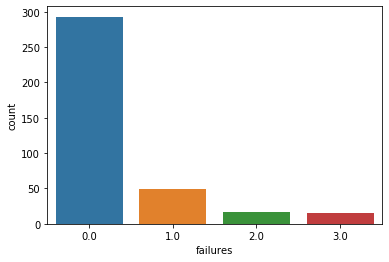

In [121]:
#количество "неудов" по другим предметам (не математике)
display(pd.DataFrame(df.failures.value_counts(normalize = True))) 
print('Пропущено {} значений'.format(df.failures.isnull().sum()))
sns.countplot(df.failures)

,schoolsup
False,0.867876
True,0.132124


Пропущено 9 значений


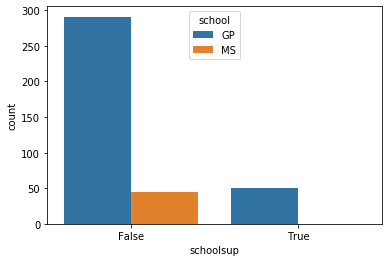

In [122]:
#Помогает ли школа
display(pd.DataFrame(df.schoolsup.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.schoolsup.isnull().sum()))
sns.countplot(x="schoolsup", hue = "school", data=df)

Видим, что школьная поддержка (видимо дополнительные занятия) предусмотрена только в школе GP.

Среди получающих поддержку от школы людей, не хотящих получить высшее образование 1 человек. 


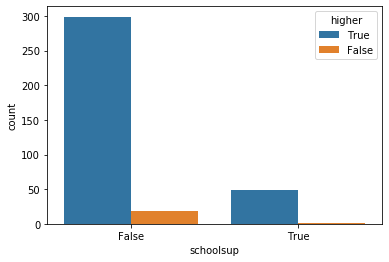

In [131]:
sns.countplot(x="schoolsup", hue = "higher", data=df)
print('Среди получающих поддержку от школы людей, не хотящих получить высшее образование {} человек. '.format(
    df[df.higher == False].schoolsup.value_counts()[True],
     )

Можно сделать вывод, что абсолютное большинство учеников, не хотящих получить высшее образование, не получает поддержку от школы. 

,famsup
True,0.615169
False,0.384831


Пропущено 39 значений


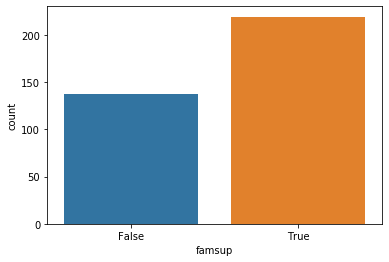

In [30]:
#Cемейная поддержка
display(pd.DataFrame(df.famsup.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.famsup.isnull().sum()))
sns.countplot(df.famsup)

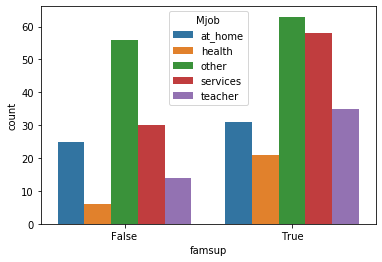

In [141]:
sns.countplot(x="famsup", hue = "Mjob", data=df)

Среди мам в семьях, которые помогают детям с учёбой, существенно больше учителей, служащих и докторов. Но преобладает категория other. Анализ аналогичного графика для места работы отца не выявил существенных закономерностей.

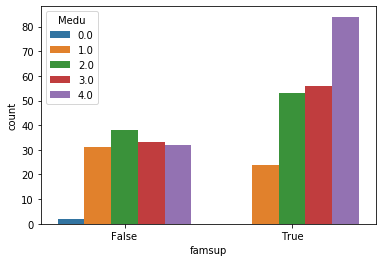

In [144]:
sns.countplot(x="famsup", hue = "Medu", data=df)

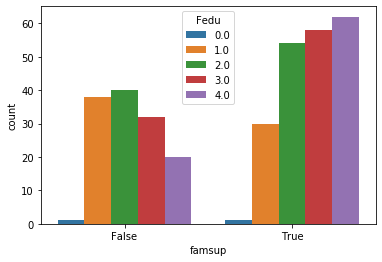

In [145]:
sns.countplot(x="famsup", hue = "Fedu", data=df)

Заметно, что образование влияет, так как виден возрастающий тренд в категории True, и ниспадающий, соответственно, в категории False

,paid
False,0.56338
True,0.43662


Пропущено 40 значений


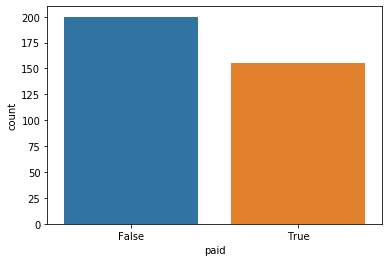

In [6]:
#Платные курсы математики
display(pd.DataFrame(df.paid.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.paid.isnull().sum()))
sns.countplot(df.paid)

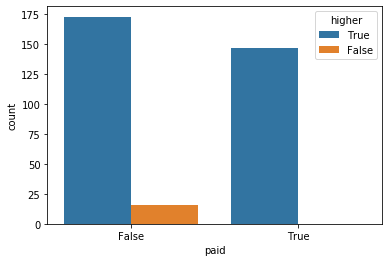

In [147]:
sns.countplot(x="paid", hue = "higher", data=df)

Среди тех, кто берет платные курсы математики все хотят получить высшее образование.

,activities
True,0.511811
False,0.488189


Пропущено 14 значений


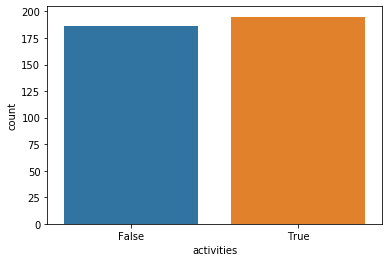

In [32]:
#дополнительные внеучебные занятия
display(pd.DataFrame(df.activities.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.activities.isnull().sum()))
sns.countplot(df.activities)

,nursery
True,0.791557
False,0.208443


Пропущено 16 значений


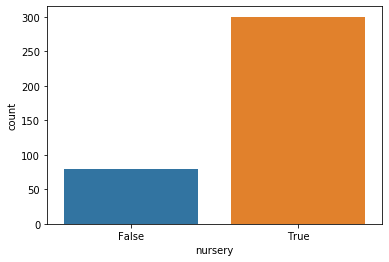

In [33]:
#Ходил ли в детский сад
display(pd.DataFrame(df.nursery.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.nursery.isnull().sum()))
sns.countplot(df.nursery)

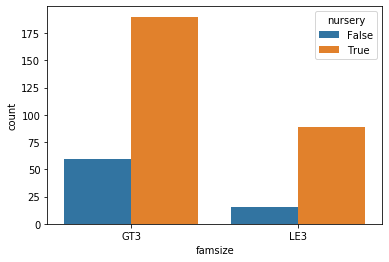

In [155]:
sns.countplot(x="famsize", hue = "nursery", data=df)

In [158]:
print(df[df.famsize == 'GT3'].nursery.value_counts(normalize = True))
print(df[df.famsize == 'LE3'].nursery.value_counts(normalize = True))
#в больших семьях больший процент детей не ходивших в детский сад

True     0.763052
False    0.236948
Name: nursery, dtype: float64
True     0.855769
False    0.144231
Name: nursery, dtype: float64


,higher
True,0.949333
False,0.050667


Пропущено 20 значений


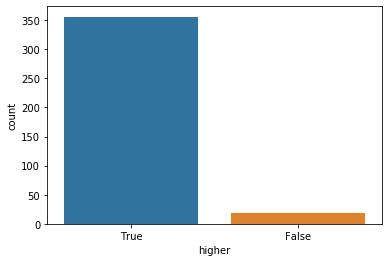

In [166]:
#Число желающих получить высшее образование
display(pd.DataFrame(df.higher.value_counts(normalize = True)))
print('Пропущено {} значений'.format(df.higher.isnull().sum()))
sns.countplot(df.higher)

Всего пять процентов не собирается получить высшее образование. Взглянем на них детальнее. Мы уже выяснили, что почти никто из них не получает поддержку от школы, и никто не брал платные курсы математики.

In [9]:
perc_false=round(df[(df.higher == False)].failures.value_counts(normalize = True)[1:].sum()*100,2)
perc_all=round((len(df[df.failures>0])/len(df))*100,2)
print('У {} % учеников, не желающих получать высшее образование, есть неудовлетворительные оценки'.format(perc_false))
print('Доля учеников с "неудами" от общего числа учеников - {} %'.format(perc_all))

У 61.11 % учеников, не желающих получать высшее образование, есть неудовлетворительные оценки
Доля учеников с "неудами" от общего числа учеников - 20.25 %


То есть среди учеников не желающих получить образование мы чаще видим двоечников.

,internet
True,305
False,56


Пропущено 34 значений


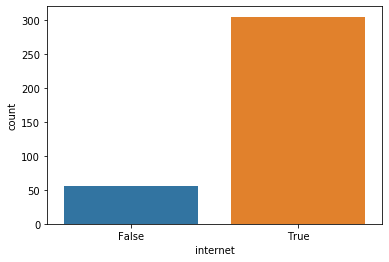

In [35]:
#Наличие подключения к интернету
display(pd.DataFrame(df.internet.value_counts()))
print('Пропущено {} значений'.format(df.internet.isnull().sum()))
sns.countplot(df.internet)

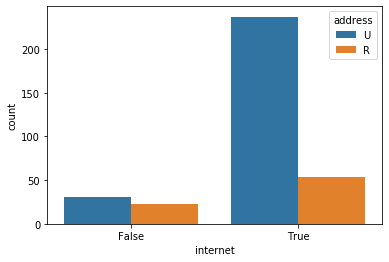

In [180]:
sns.countplot(x="internet", hue = "address", data=df)
#Заметно что в городе людей с подключением к интернету существенно больше чем без. В сельской местности промежуток не так велик.

,romantic
False,240
True,124


Пропущено 31 значений


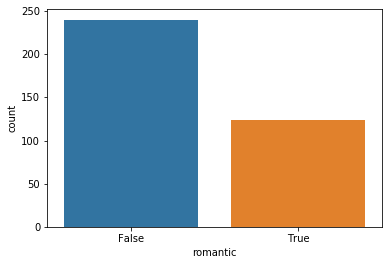

In [36]:
display(pd.DataFrame(df.romantic.value_counts()))
print('Пропущено {} значений'.format(df.romantic.isnull().sum()))
sns.countplot(df.romantic)

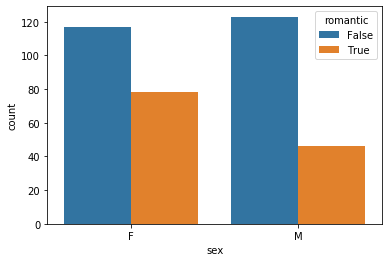

In [185]:
sns.countplot(x="sex", hue = "romantic", data=df)

В основном дети не состоят в романтических отношениях, но состоит больше девушек чем парней. По небинарным категориям число детей и состоящих и не состоящих в романтических отношениях распределено приблизительно нормально.

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


Пропущено 27 значений


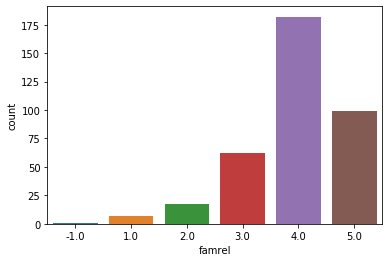

In [37]:
display(pd.DataFrame(df.famrel.value_counts()))
print('Пропущено {} значений'.format(df.famrel.isnull().sum()))
sns.countplot(df.famrel)
#-1 cкорее всего опечатка

In [7]:
#исправим опечатку
df.loc[df.famrel == -1, 'famrel'] = 1

Преобладают семьи с хорошим отношением.

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


Пропущено 11 значений


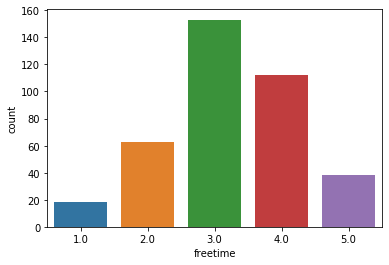

In [39]:
#Количество свободного времени
display(pd.DataFrame(df.freetime.value_counts()))
print('Пропущено {} значений'.format(df.freetime.isnull().sum()))
sns.countplot(df.freetime)

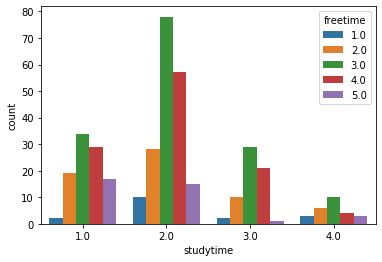

In [201]:
sns.countplot(x="studytime", hue = "freetime", data=df)

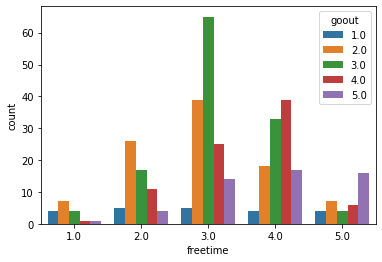

In [202]:
sns.countplot(x="freetime", hue = "goout", data=df)

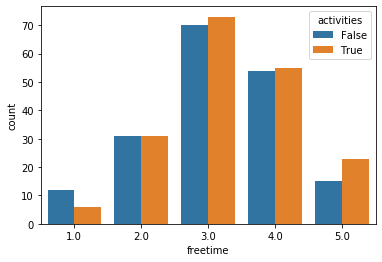

In [203]:
sns.countplot(x="freetime", hue = "activities", data=df)

Выходит, что большинство учится/отдыхает сбалансировано. Но те у кого больше свободного времени, больше гуляют и тратят на внеклассные активности

,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


Пропущено 8 значений


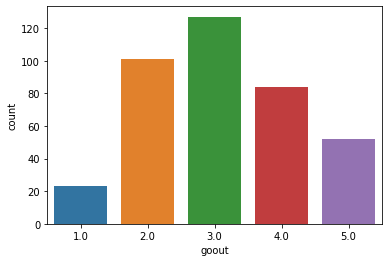

In [204]:
#количество времени проведенного с друзьями
display(pd.DataFrame(df.goout.value_counts()))
print('Пропущено {} значений'.format(df.goout.isnull().sum()))
sns.countplot(df.goout)

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


Пропущено 15 значений


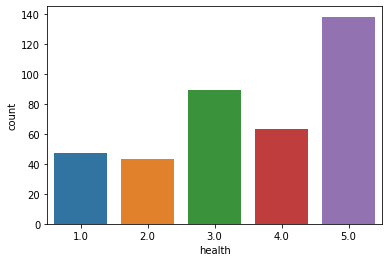

In [205]:
#Состояние здоровья
display(pd.DataFrame(df.health.value_counts()))
print('Пропущено {} значений'.format(df.health.isnull().sum()))
sns.countplot(df.health)

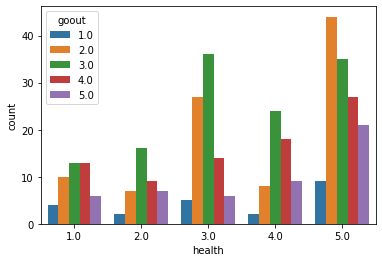

In [207]:
sns.countplot(x="health", hue = "goout", data=df)
#видим что по категориям этот признак распределен приблизительно нормально,
#и даже дети с неудовлитворительным состоянием здоровья скорее гуляют с друзьями, чем нет

,"studytime, granular"
-6.0,0.500000
-3.0,0.265464
-9.0,0.164948
-12.0,0.069588


Пропущено 7 значений


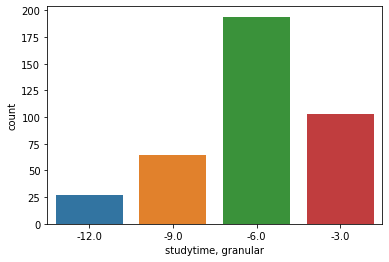

In [214]:
display(pd.DataFrame(df['studytime, granular'].value_counts(normalize = True)))
display(sns.countplot(df['studytime, granular']))
print('Пропущено {} значений'.format(df['studytime, granular'].isnull().sum()))
# очевидно, что это колонка studytime умноженная на -3
# возможно это было нужно сборщикам данных чтобы инвертировать признак
# посмотрим совпадают ли пропуски данных, чтобы понять, можем ли мы восстановить одну колонку с помощью другой

In [218]:
df[df.studytime.isnull()]['studytime, granular'].unique()
#пропущенные данные полностью совпадают

array([nan])

,absences
count,383.000000
mean,7.279373
std,23.465197
min,0.000000
25%,0.000000
50%,4.000000
75%,8.000000
max,385.000000


Пропущено 12 значений
Пропущено 12 значений


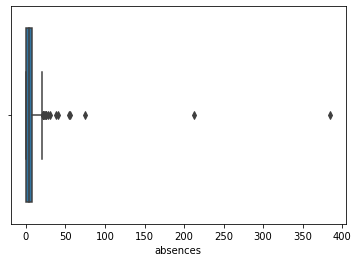

In [219]:
#количество прогулов
display(pd.DataFrame(df.absences.describe()))
print('Пропущено {} значений'.format(df.absences.isnull().sum()))
sns.boxplot(df.absences)

Видим, что есть как минимум два очень сильных выброса, посмотрим на них детальнее, чтобы понять не может ли это быть опечаткой.

In [42]:
median = df.absences.median()
IQR = df.absences.quantile(0.75) - df.absences.quantile(0.25)
perc25 = df.absences.quantile(0.25)
perc75 = df.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


In [220]:
df[df.absences > 20]
# видим два значения, которые не похожи на правду 385 и 212, 
# будем считать опечатками в дальнейшем заменим их после оценки целевой переменной - score

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,False,NaN,False,True,False,-6.0,True,True,True,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,True,True,True,True,True,-6.0,True,True,False,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,True,True,True,False,True,-6.0,True,True,False,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,False,True,False,True,True,-6.0,True,True,True,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,False,True,False,False,True,-3.0,True,NaN,False,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,False,True,True,False,True,-9.0,True,True,True,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,False,False,True,False,True,-6.0,True,True,True,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,True,NaN,False,False,True,-6.0,True,True,False,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,False,True,True,False,True,-6.0,True,True,True,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,False,NaN,False,False,False,-6.0,False,True,True,NaN,1.0,1.0,5.0,75.0,45.0


,score
count,389.000000
mean,52.262211
std,22.919022
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,100.000000


Пропущено 6 значений


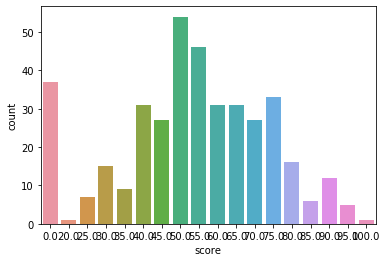

In [41]:
display(pd.DataFrame(df.score.describe()))
print('Пропущено {} значений'.format(df.score.isnull().sum()))
sns.countplot(df.score)

In [45]:
median = df.score.median()
IQR = df.score.quantile(0.75) - df.score.quantile(0.25)
perc25 = df.score.quantile(0.25)
perc75 = df.score.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


In [8]:
# ниже мы выяснили, что колонки absences и score - слабоскореллированны, заменим экстремально большие значения прогулов
# на средние для оценок в категории "больше 80 баллов" и "от 30 до 50"
df.loc[df.absences == 385, 'absences'] = round(df[(df.score > 80) & (df.absences < 200)].absences.mean())
df.loc[df.absences == 212, 'absences'] = round(df[(df.score >= 30) & (df.score <= 50) & (df.absences < 200)].absences.mean())

# Бивариантный анализ Сontinous/Continous

In [16]:
df_cont = df.loc[:,['absences','score']]
df_cont = df_cont[df_cont.absences <= 20] #отсечем выбросы по прогулам и посмотрим корреляцию

,absences,score
absences,1.000000,0.080711
score,0.080711,1.000000


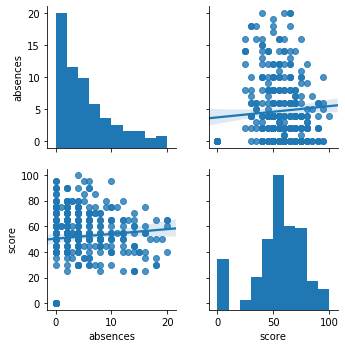

In [17]:
display(df_cont.corr())
sns.pairplot(df_cont, kind = 'reg')
#abscences и score слабоскореллированы

# Бивариантный анализ Categorical/Continous

In [116]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 10))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

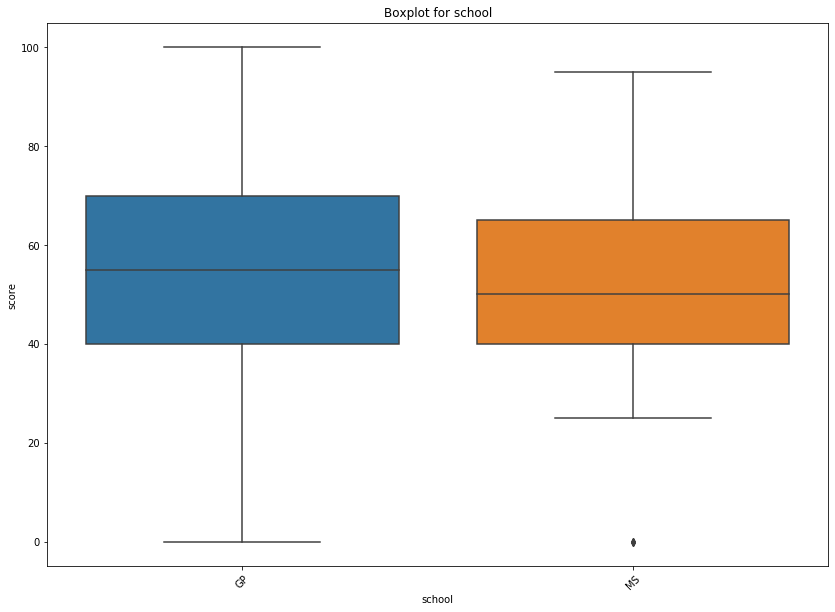

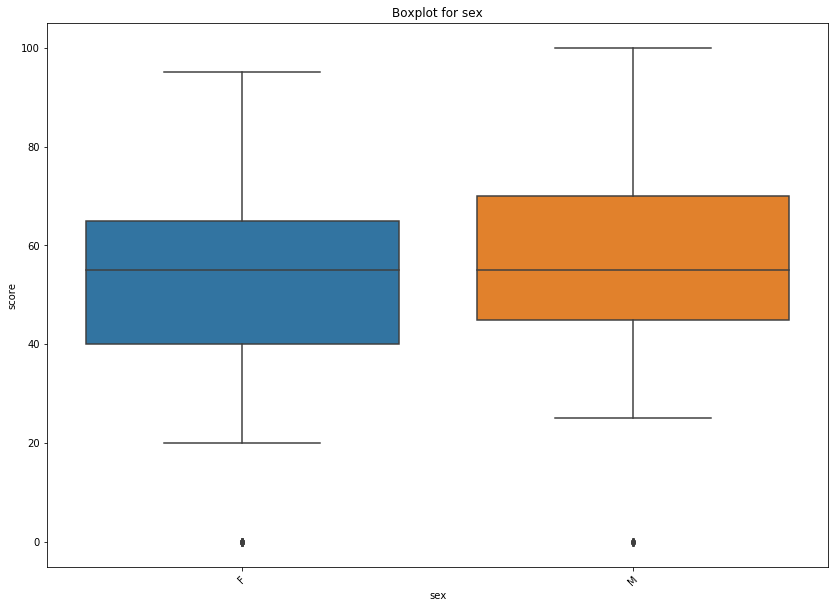

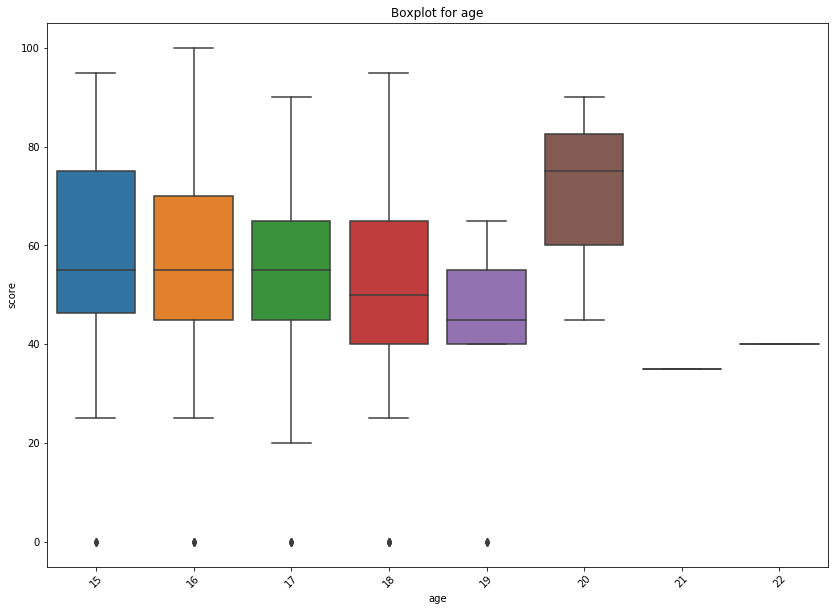

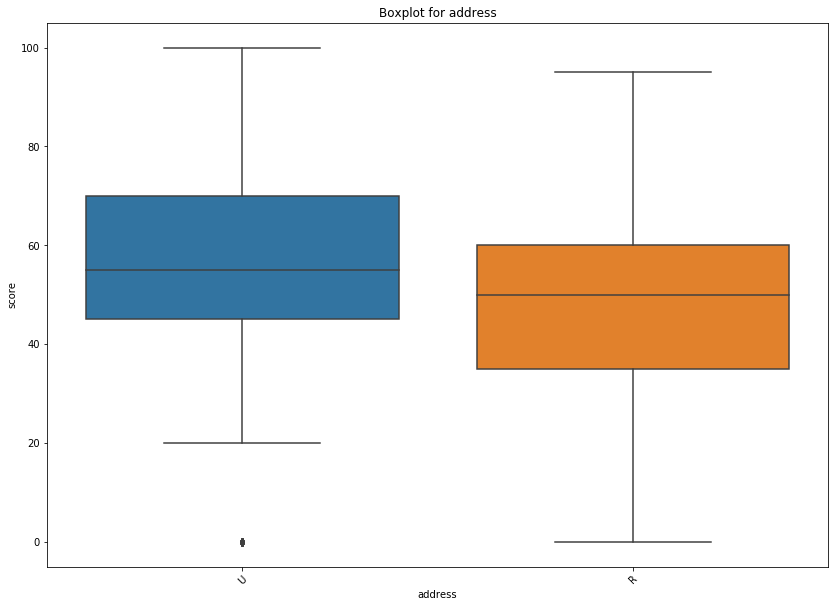

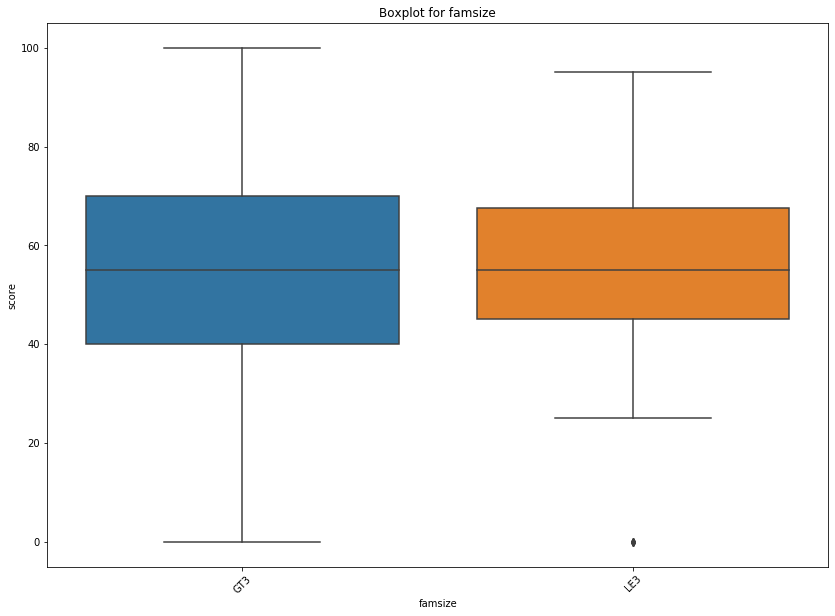

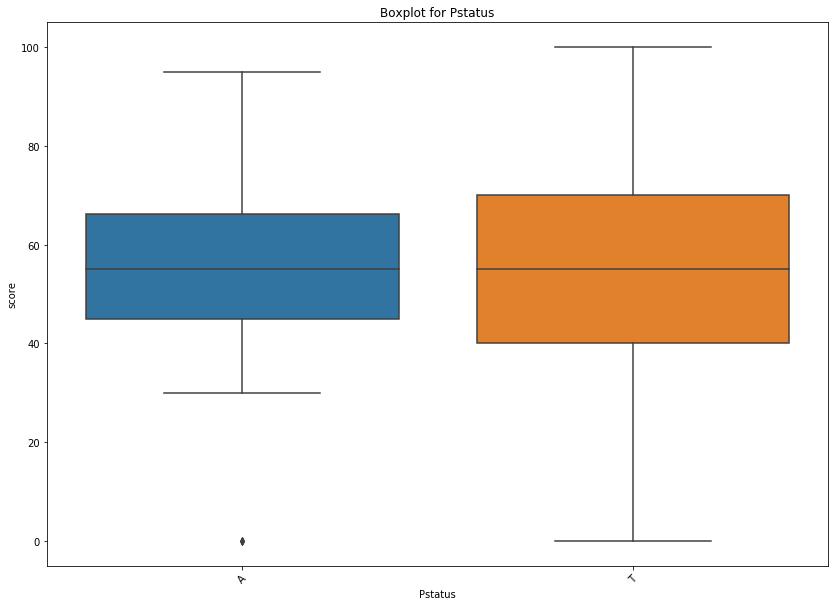

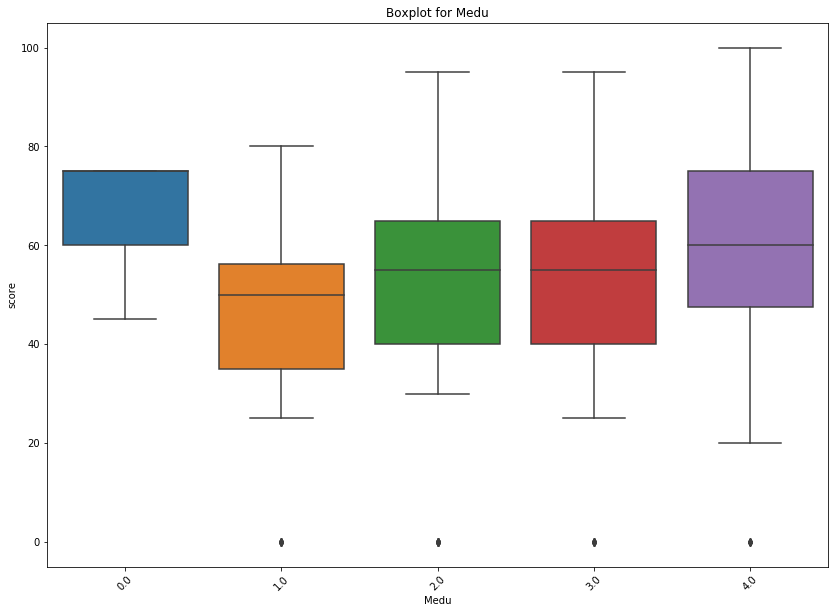

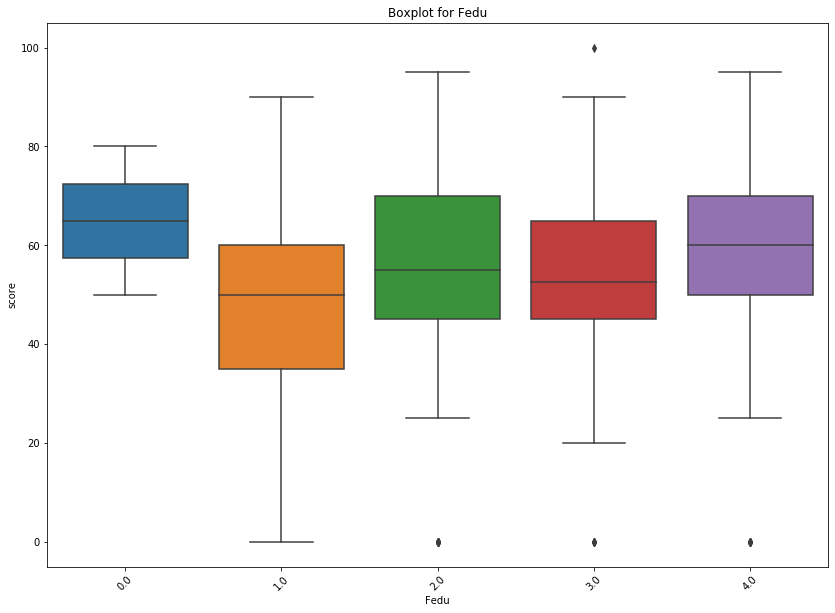

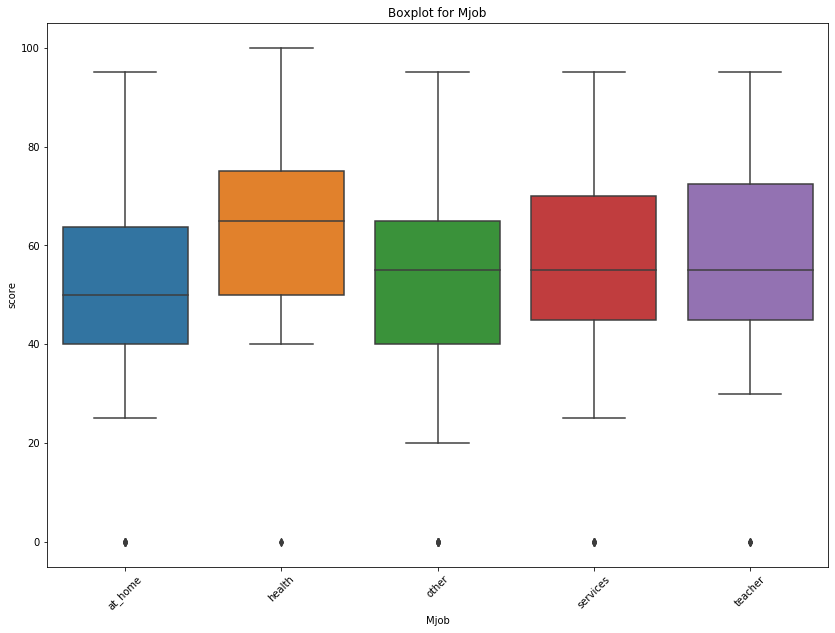

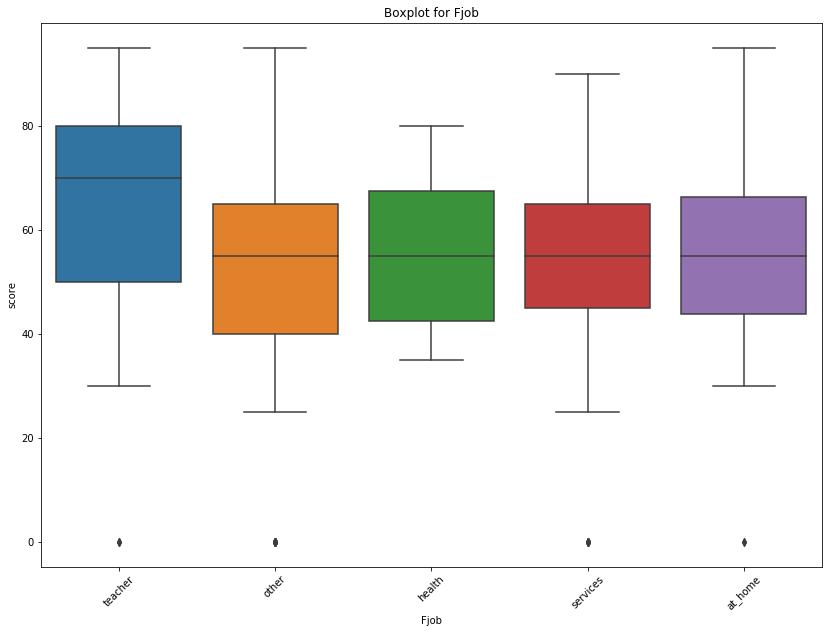

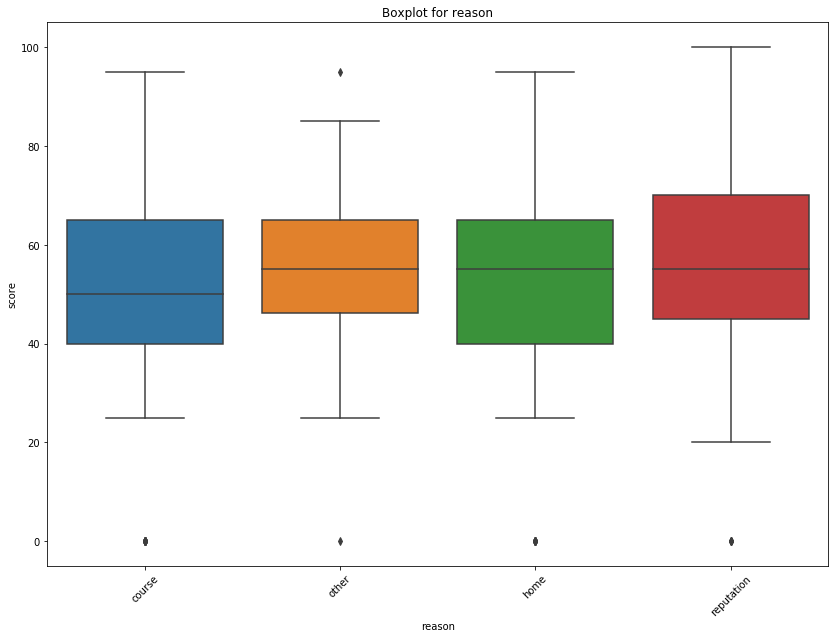

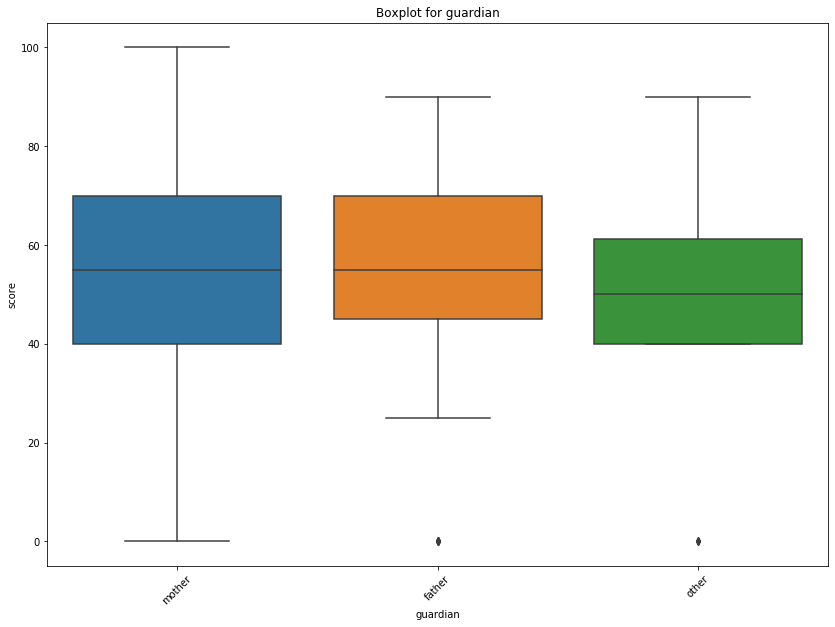

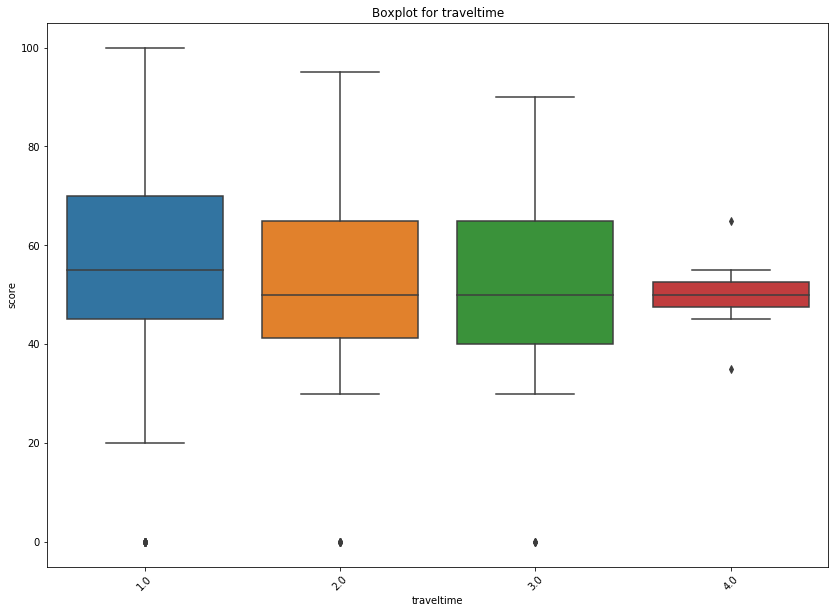

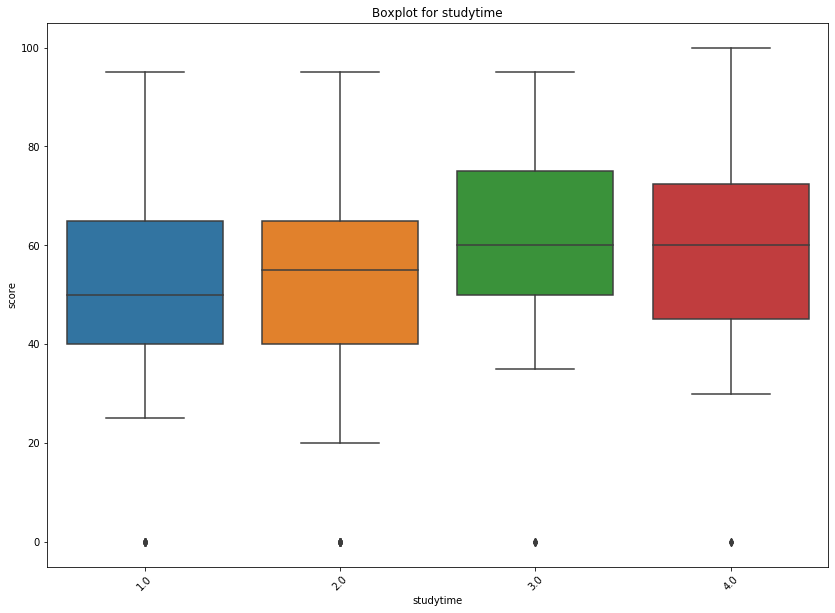

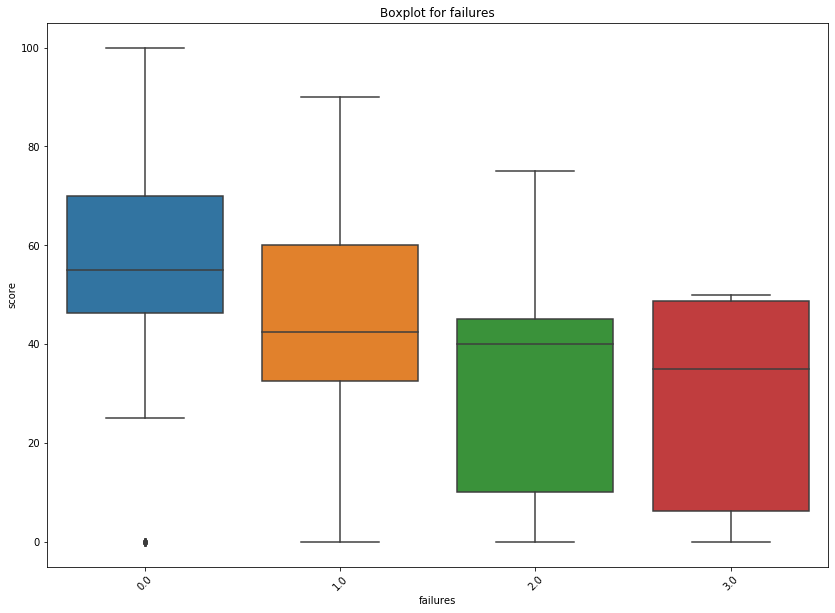

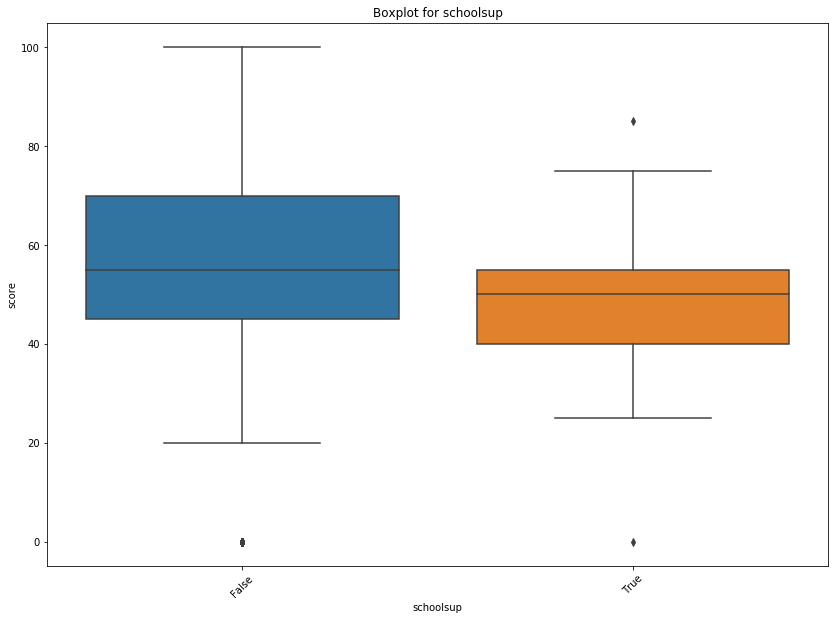

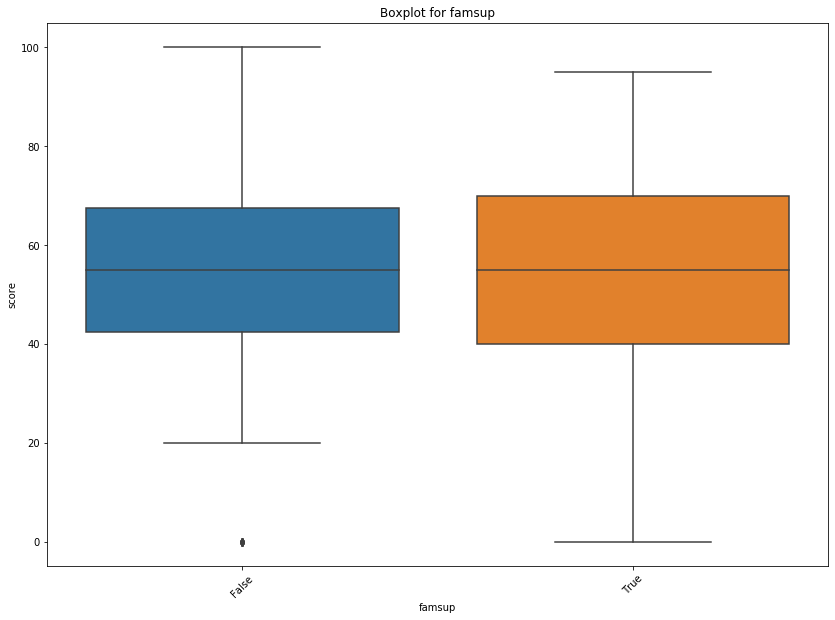

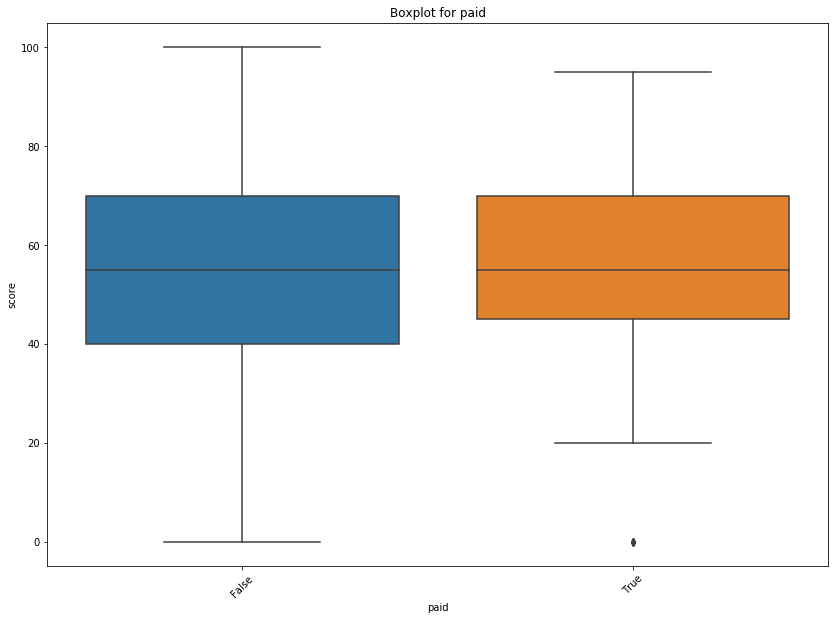

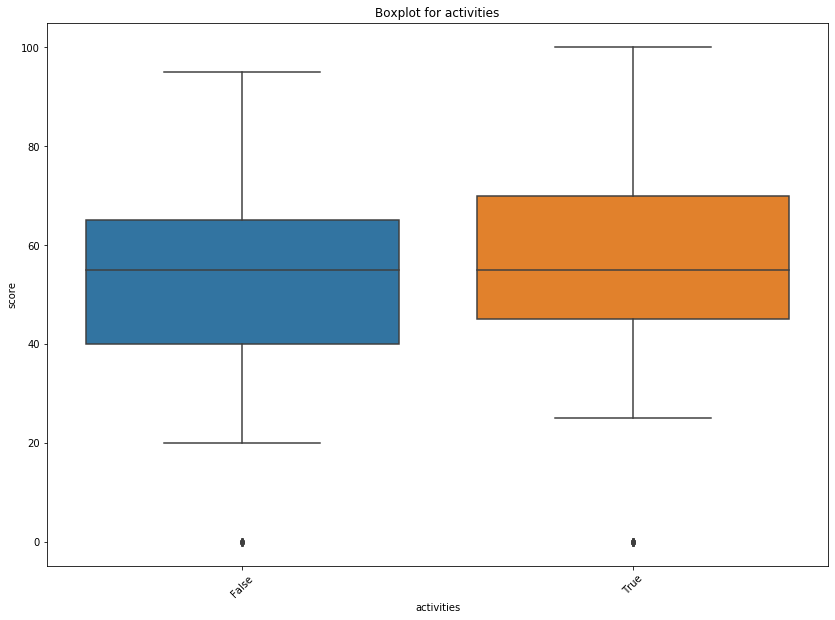

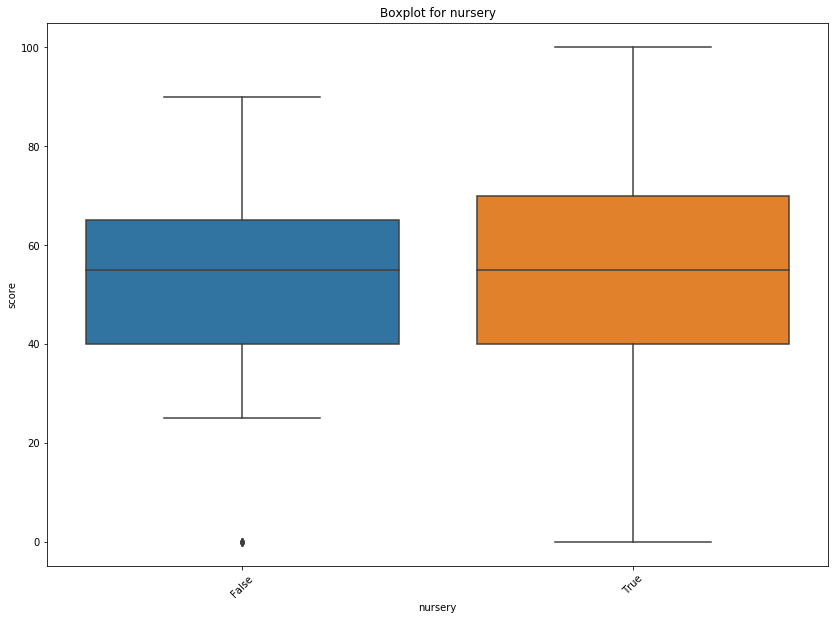

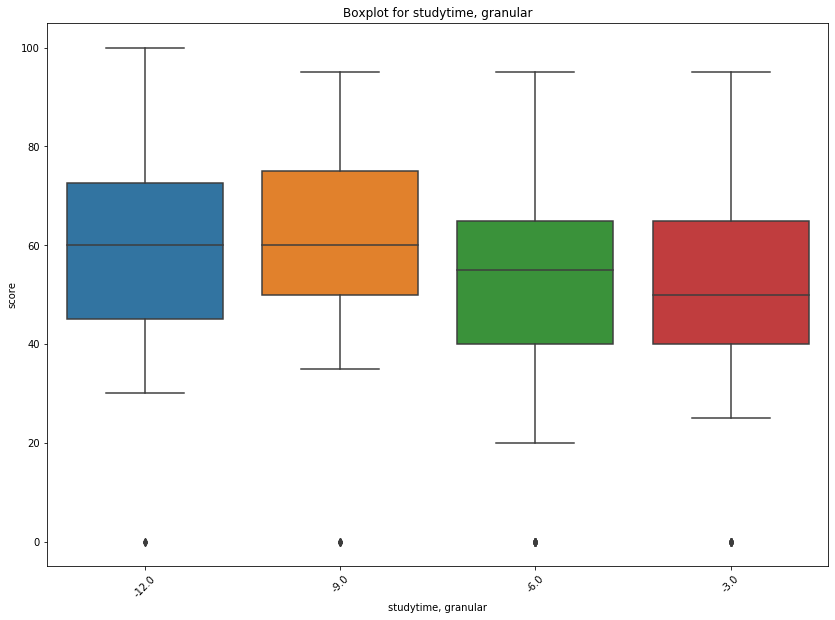

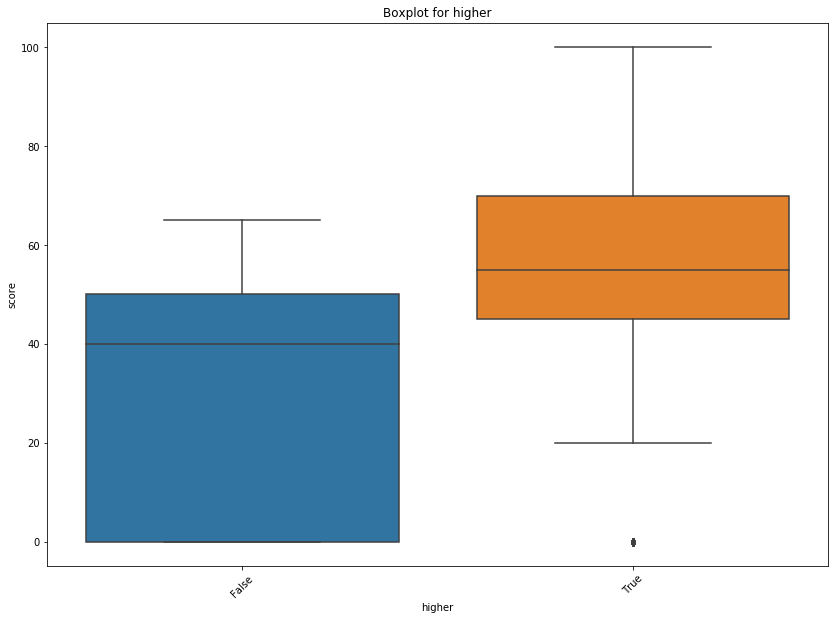

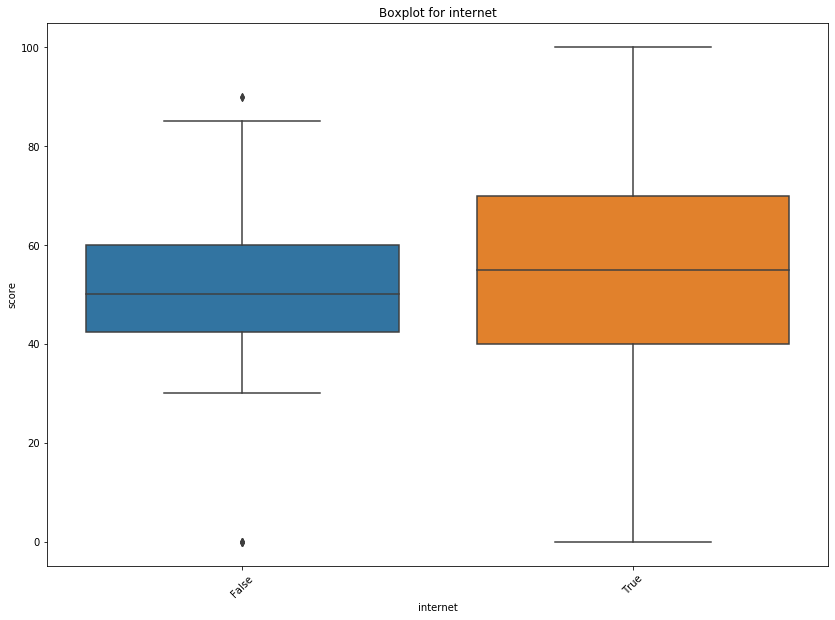

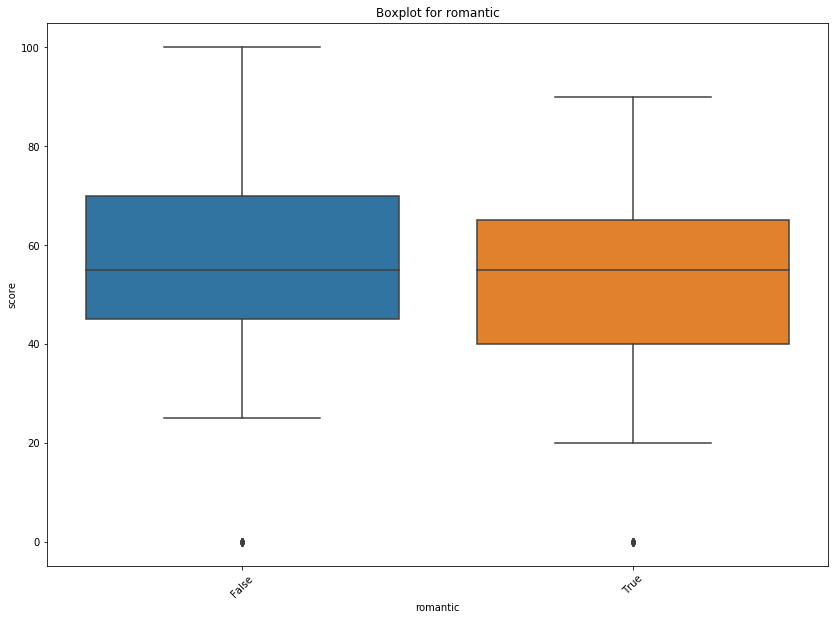

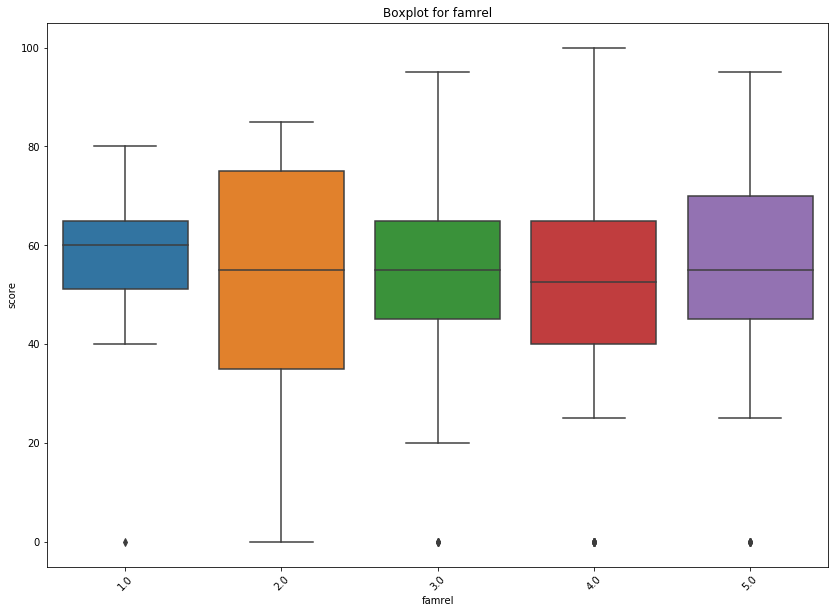

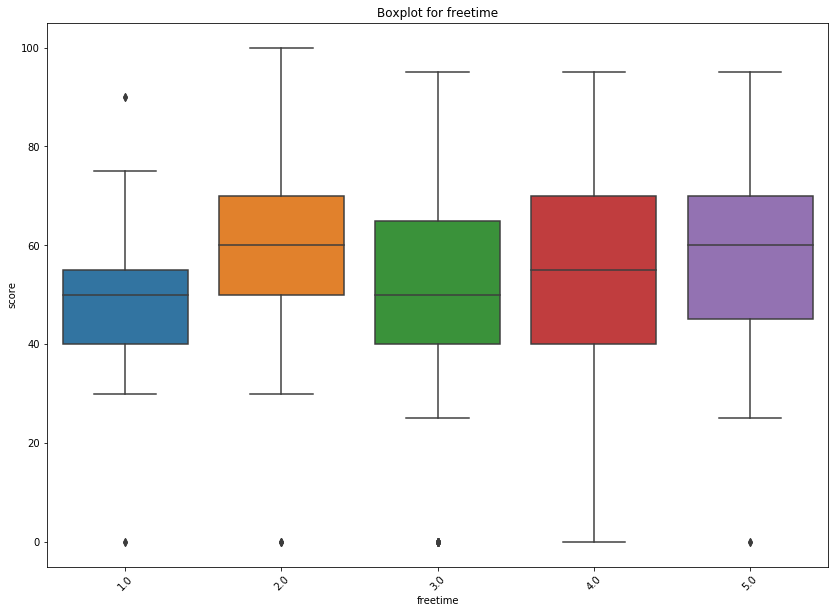

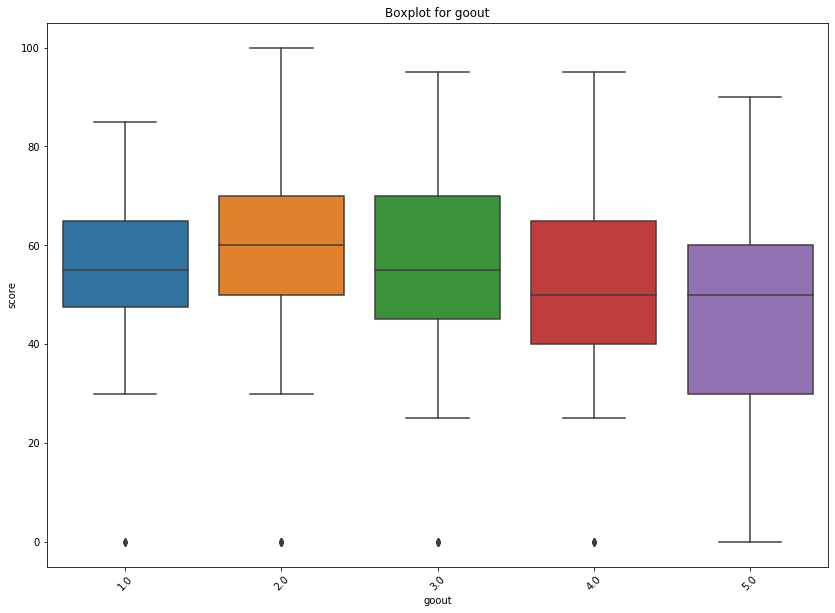

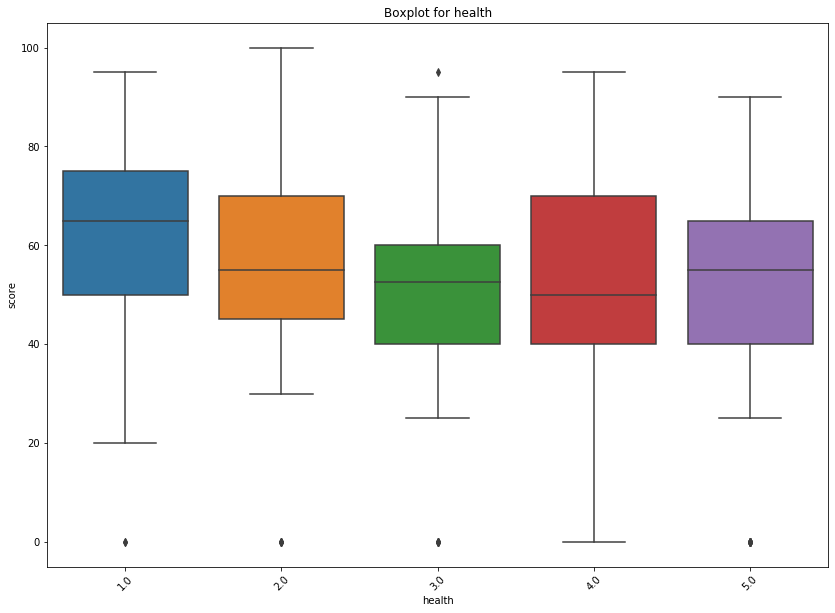

In [19]:
for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health']:
    get_boxplot(col) # построим боксплоты для всех колонок

In [113]:
def get_stat_dif (column,c):
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], c], 
            df.loc[df.loc[:, column] == comb[1], c], nan_policy = 'omit').pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
#до замены проигнорировали пропуски c помощью параметра nan_policy

In [21]:
for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health']:
    get_stat_dif(col,'score')

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки goout


In [22]:
#из интереса попробуем применить ту же функцию для прогулов.
for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health']:
    get_stat_dif(col,'absences')

Найдены статистически значимые различия для колонки age
Найдены статистически значимые различия для колонки Pstatus
Найдены статистически значимые различия для колонки reason
Найдены статистически значимые различия для колонки guardian
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки romantic


## Наблюдения и восстановление пропущенных значений


In [132]:
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4,4,at_home,teacher,course,mother,2,2,0,True,False,False,False,True,-6,True,NaN,False,4,3,4,3,6.0,30.0
1,GP,F,17,U,GT3,NaN,1,1,at_home,other,course,father,1,2,0,False,True,False,False,False,-6,True,True,False,5,3,3,3,4.0,30.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,True,False,NaN,False,True,-6,True,True,NaN,4,3,2,3,10.0,50.0
3,GP,F,15,U,GT3,T,4,2,health,NaN,home,mother,1,3,0,False,True,True,True,True,-9,True,True,True,3,2,2,5,2.0,75.0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,False,True,True,False,True,-6,True,False,False,4,3,2,5,4.0,50.0


Применим функции-филлеры ко всем колонкам, основываясь на небольшом исследовании, проведенном выше при отсмотре данных.

In [40]:
c = 'address'
c_list = ['school','traveltime']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df.address.isnull().sum()))

Осталось 3 пропущенных значений


In [16]:
# т.к. среди признаков на которые мы опираемся могут быть тоже значения 'Nan', поэтому после того
# как мы восстановим все хотя бы частично, мы повторим эти функции к уже измененному датафрейму

In [41]:
c = 'famsize'
c_list = ['Fedu','Medu','Mjob','Fjob','Pstatus'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df.famsize.isnull().sum()))

Осталось 11 пропущенных значений


In [42]:
c = 'Pstatus'
c_list = ['famsize', 'guardian', 'Mjob', 'Fjob' ] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 7 пропущенных значений


In [43]:
c = 'Medu'
c_list = ['Mjob'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [14]:
c = 'Fedu'
c_list = ['Fjob'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 2 пропущенных значений


In [15]:
c = 'Mjob'
c_list = ['Medu'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [16]:
c = 'Fjob'
c_list = ['Fedu'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 2 пропущенных значений


Видим, что количество пропущенных значений в Fjob и Fedu совпадает, проверим не одинаковые ли это строки.
Если да, и параметр guardian cоответствует, то можем предположить, что это скрытый ноль и отец в семье отсутствует.

In [17]:
df[df.Fjob.isnull()]
#в обоих случаях опекун - мама, значит в этих случаях у нас скорее всего нет отца

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
161,GP,M,15,R,GT3,T,3.0,NaN,other,NaN,course,mother,2.0,2.0,2.0,True,True,False,False,True,-6.0,True,True,True,4.0,4.0,4.0,3.0,6.0,35.0
374,MS,F,18,R,LE3,T,4.0,NaN,other,NaN,reputation,mother,2.0,3.0,0.0,False,False,False,False,True,-9.0,True,True,False,5.0,4.0,4.0,1.0,0.0,95.0


In [17]:
df['Fedu'] = df['Fedu'].fillna('absent')
df['Fjob'] = df['Fjob'].fillna('absent')

In [18]:
c = 'reason'
c_list = ['school', 'address', 'Medu', 'Fedu'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [44]:
c = 'guardian'
c_list = ['Mjob', 'Fjob'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 1 пропущенных значений


In [45]:
c = 'traveltime'
c_list = ['address', 'school','reason'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 3 пропущенных значений


In [46]:
c = 'studytime'
c_list = ['sex','traveltime', 'freetime','goout', 'romantic', 'internet', 'health', 'failures'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 4 пропущенных значений


In [47]:
c = 'failures'
c_list = ['studytime', 'famsup','schoolsup', 'freetime', 'higher'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 4 пропущенных значений


In [48]:
c = 'schoolsup'
c_list = ['school','higher'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [99]:
c = 'famsup'
c_list = ['Fedu','Medu', 'Pstatus', 'guardian'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 2 пропущенных значений


In [100]:
c = 'famsup'
c_list = ['Fjob', 'Mjob'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [108]:
c = 'paid'
c_list = ['higher'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [50]:
c = 'activities'
c_list = ['freetime', 'goout', 'romantic', 'health', 'internet'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 6 пропущенных значений


In [97]:
c = 'nursery'
c_list = ['Mjob', 'guardian','famsize'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [52]:
c = 'studytime, granular'
c_list = ['studytime']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 4 пропущенных значений


In [103]:
c = 'higher'
c_list = ['school','reason','paid','schoolsup']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 1 пропущенных значений


In [33]:
c = 'internet'
c_list = ['higher','address','Fedu', 'Medu'] # так как в большинстве случаев в этом датасете, те у кого нет интернета хотят получить высшее образование
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [54]:
c = 'romantic'
c_list = ['sex','goout','activities','freetime']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 3 пропущенных значений


In [110]:
c = 'famrel'
c_list = ['guardian','famsup', 'Pstatus']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [56]:
c = 'freetime'
c_list = ['traveltime', 'studytime','goout', 'romantic', 'internet', 'health']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 8 пропущенных значений


In [57]:
c = 'goout'
c_list = ['traveltime', 'studytime','freetime', 'romantic', 'internet', 'health']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 6 пропущенных значений


In [39]:
c = 'health'
c_list = ['goout', 'activities']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


Повторим цикл восстановления данных для категориальных признаков по второму разу. Затем уменьшим количество взятых в расчет признаков для не до конца восстановленных колонок.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                392 non-null object
famsize                384 non-null object
Pstatus                388 non-null object
Medu                   395 non-null float64
Fedu                   395 non-null object
Mjob                   395 non-null object
Fjob                   395 non-null object
reason                 395 non-null object
guardian               394 non-null object
traveltime             392 non-null float64
studytime              391 non-null float64
failures               391 non-null float64
schoolsup              395 non-null bool
famsup                 356 non-null object
paid                   394 non-null object
activities             389 non-null object
nursery                393 non-null object
studytime, granular    391 non-nul

In [82]:
c = 'address'
c_list = ['school', 'traveltime']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df.address.isnull().sum()))

Осталось 0 пропущенных значений


In [85]:
c = 'famsize'
c_list = ['Mjob','Fjob'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df.famsize.isnull().sum()))

Осталось 0 пропущенных значений


In [86]:
c = 'Pstatus'
c_list = ['famsize', 'guardian'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [90]:
c = 'guardian'
c_list = ['Pstatus', 'famsize', 'Mjob'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [81]:
c = 'traveltime'
c_list = ['school','reason'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [77]:
c = 'studytime'
c_list = ['sex','higher'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [91]:
c = 'failures'
c_list = ['studytime', 'higher', 'sex'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [73]:
c = 'activities'
c_list = ['freetime', 'goout'] 
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [92]:
c = 'studytime, granular'
c_list = ['studytime']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [68]:
c = 'romantic'
c_list = ['sex','activities','goout']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [69]:
c = 'freetime'
c_list = ['traveltime', 'studytime']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [70]:
c = 'goout'
c_list = ['freetime', 'health']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [71]:
c_list = ['studytime', 'health', 'failures']
df.loc[:,'absences'] = df.apply(absence_filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df['absences'].isnull().sum()))

Осталось 0 пропущенных значений


In [93]:
c_list = ['address', 'Medu', 'Mjob','failures','paid','higher','romantic','goout']
df.loc[:,'score'] = df.apply(score_filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df['score'].isnull().sum()))

Осталось 4 пропущенных значений


In [94]:
#Применяем функцию и постепенно сокращаем количество взятых в расчет признаков
c_list = ['Medu', 'Mjob','failures','higher']
df.loc[:,'score'] = df.apply(score_filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df['score'].isnull().sum()))

Осталось 0 пропущенных значений


In [107]:
c = 'higher'
c_list = ['school','reason','schoolsup']
df.loc[:,c] = df.apply(filler, axis = 1)
print('Осталось {} пропущенных значений'.format(df[c].isnull().sum()))

Осталось 0 пропущенных значений


In [111]:
df.info() #вернемся и применим функции ещё раз к недозаполненым колонкам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                395 non-null object
famsize                395 non-null object
Pstatus                395 non-null object
Medu                   395 non-null float64
Fedu                   395 non-null object
Mjob                   395 non-null object
Fjob                   395 non-null object
reason                 395 non-null object
guardian               395 non-null object
traveltime             395 non-null float64
studytime              395 non-null float64
failures               395 non-null float64
schoolsup              395 non-null bool
famsup                 395 non-null bool
paid                   395 non-null bool
activities             395 non-null bool
nursery                395 non-null bool
studytime, granular    395 non-null float6

Проанализируем еще раз взаимоотношение между целевой переменной и остальными признаками

In [114]:
for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health']:
    get_stat_dif(col,'score')

Найдены статистически значимые различия для колонки age
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки goout


Видим что среди статистически значимых появился параметр age.

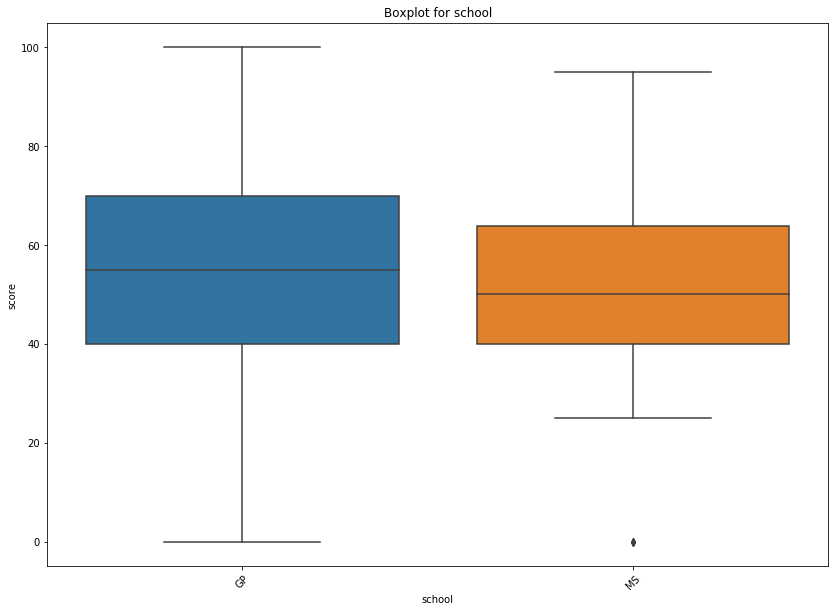

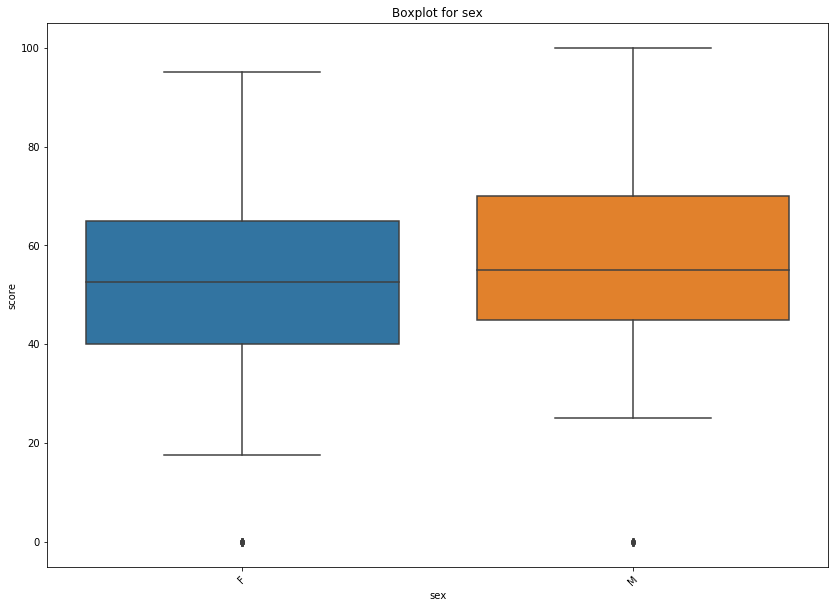

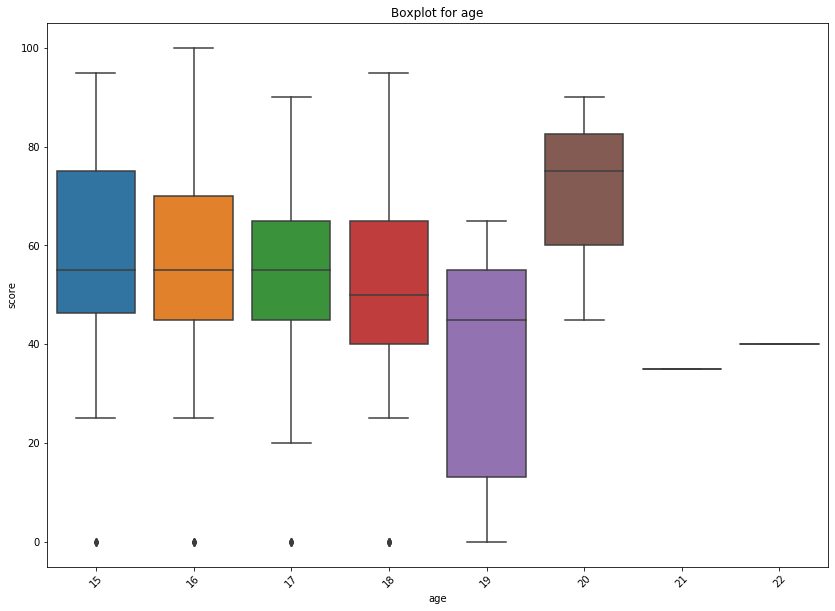

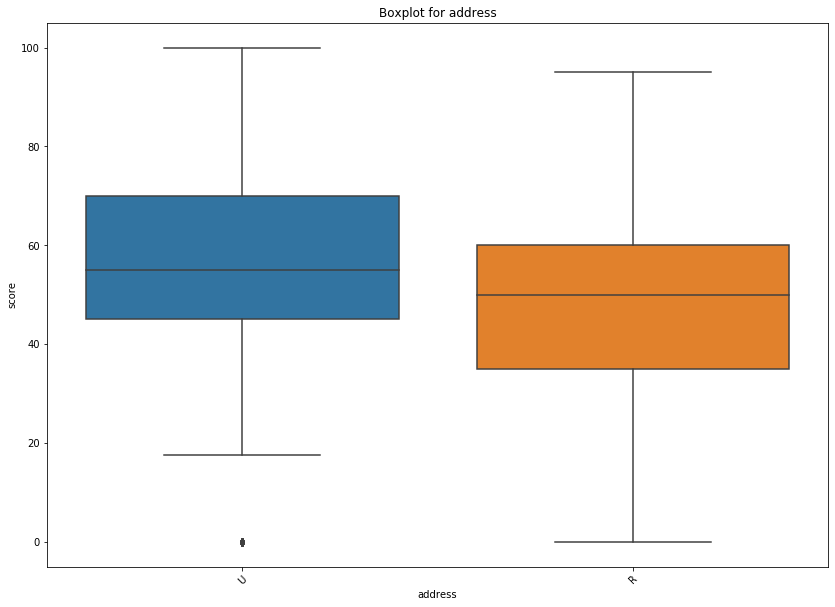

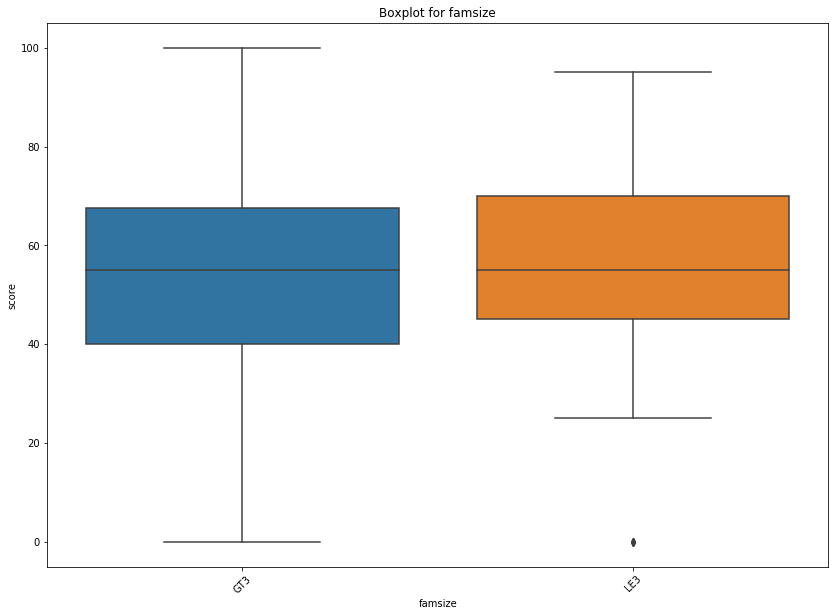

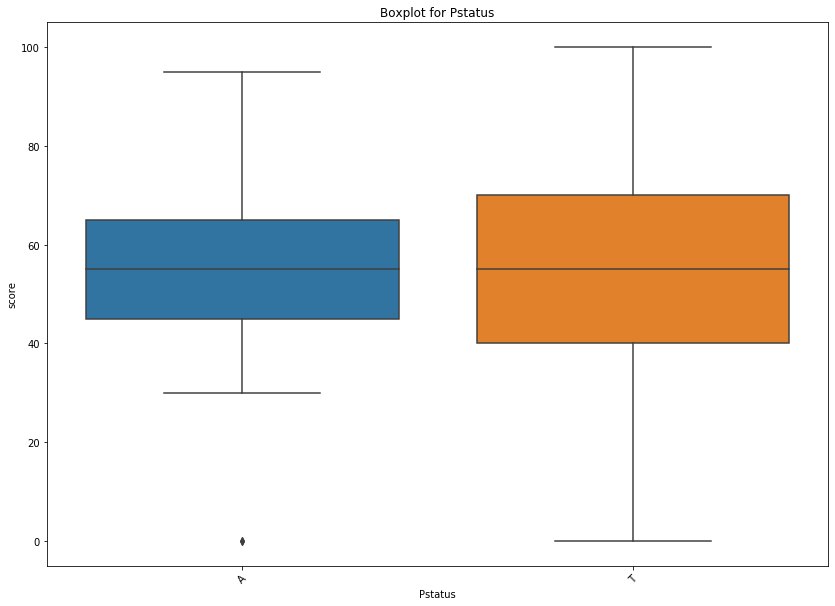

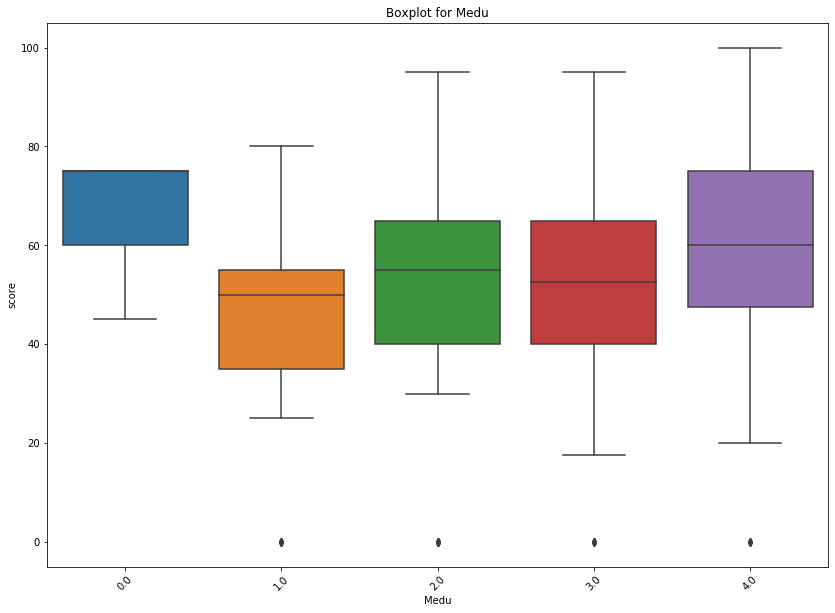

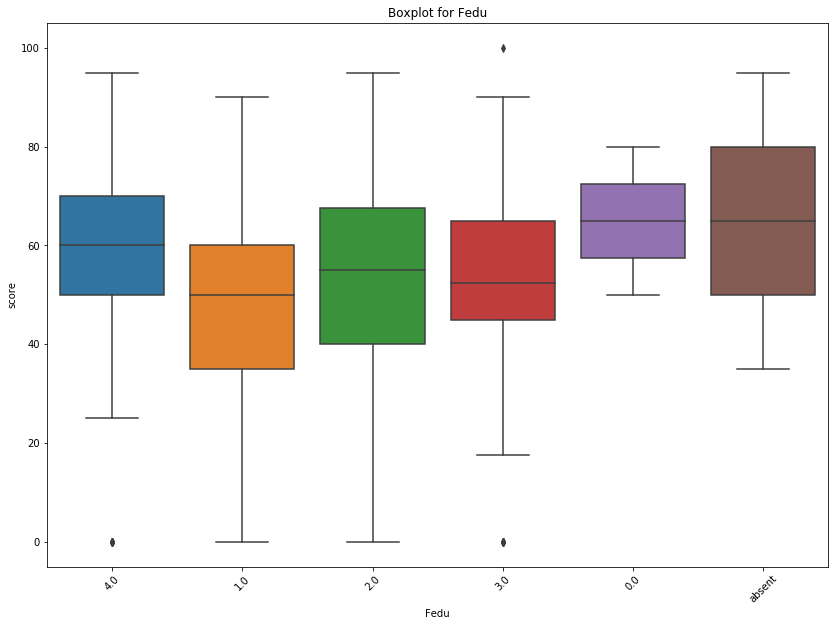

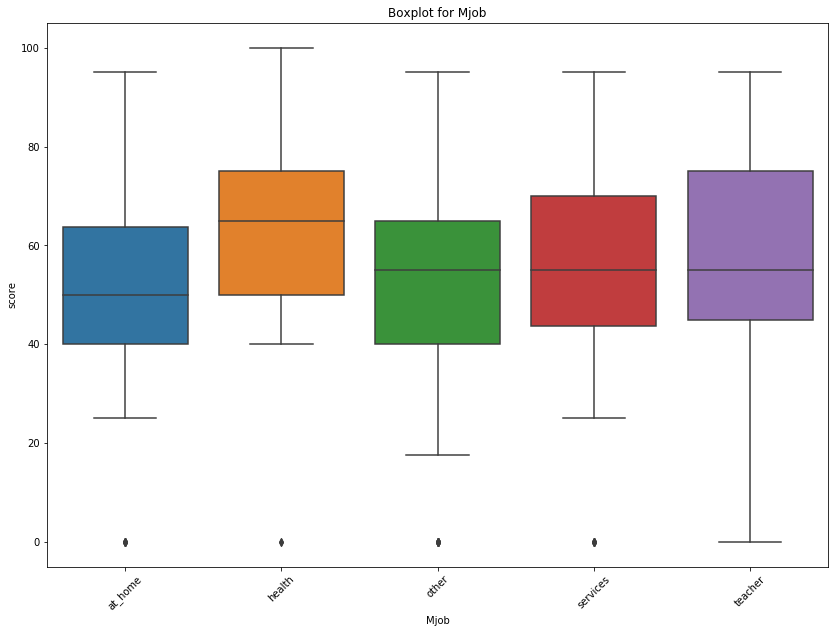

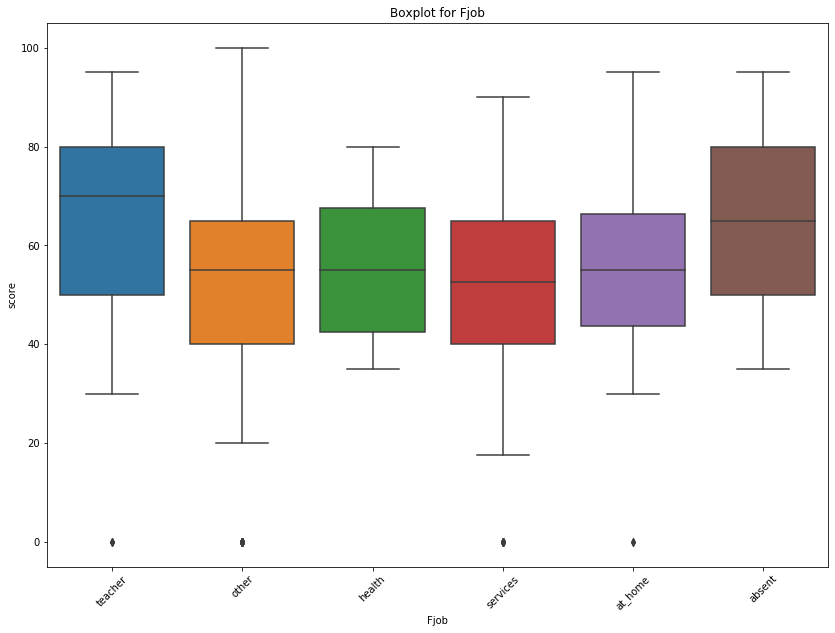

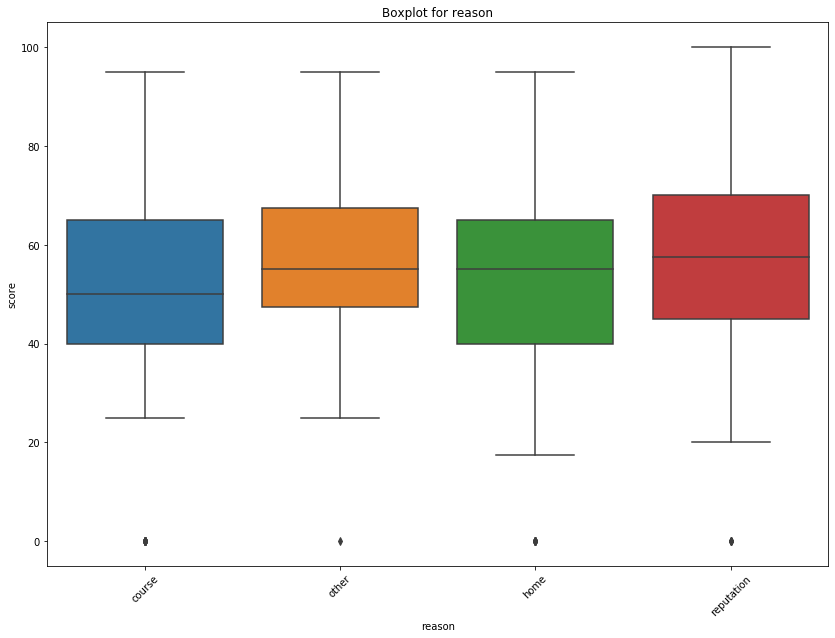

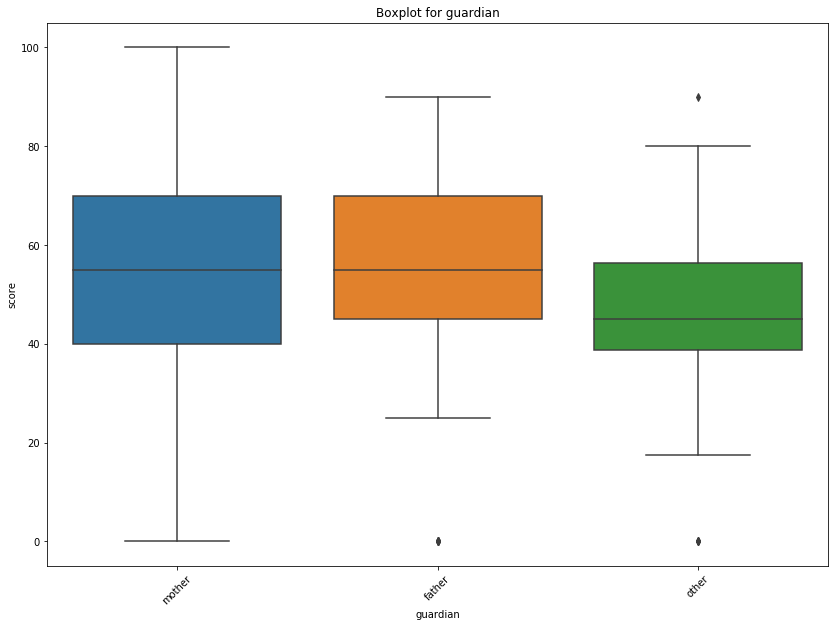

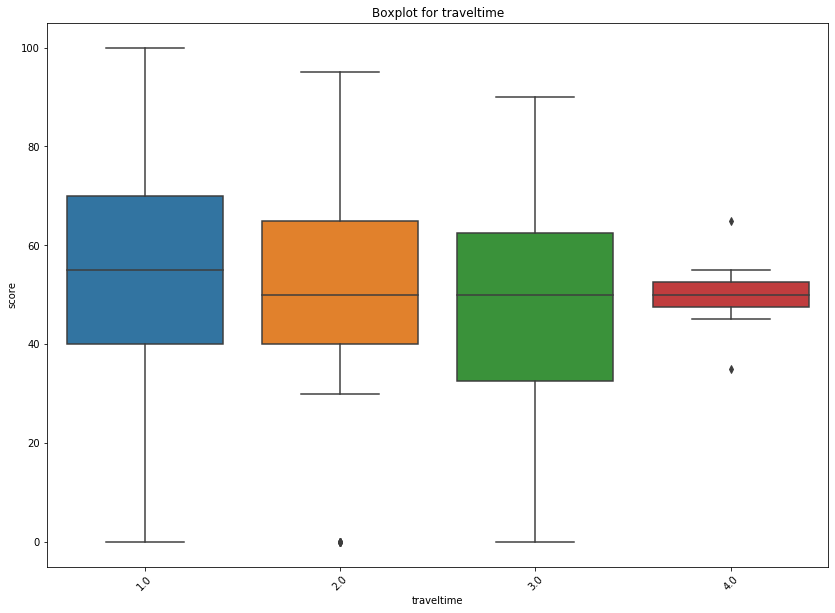

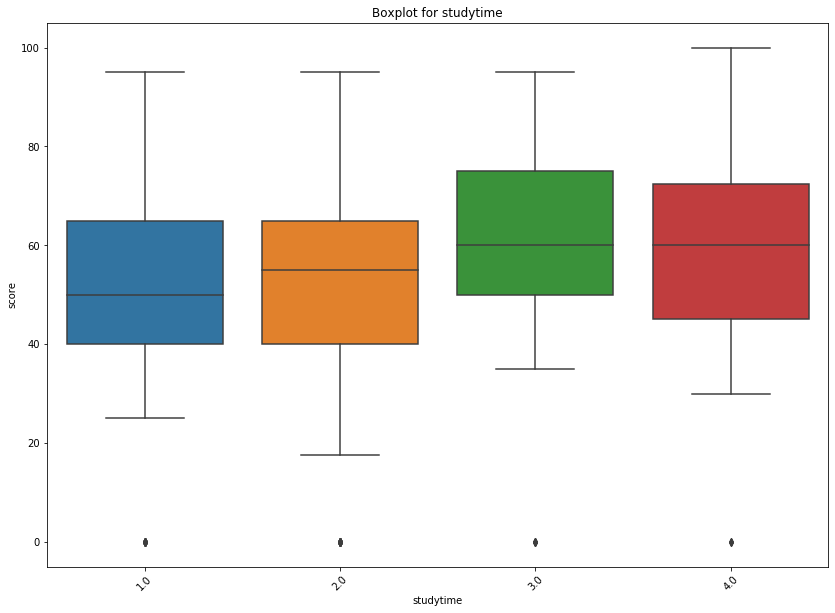

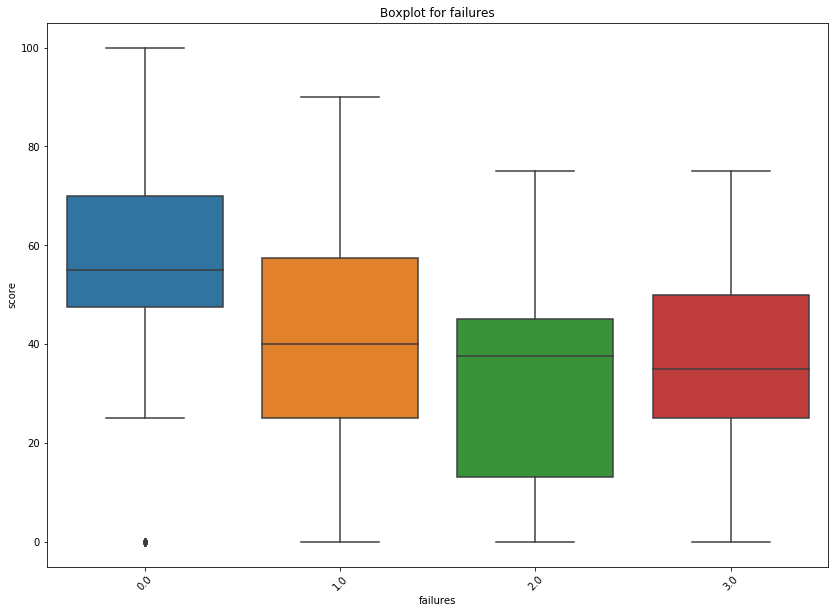

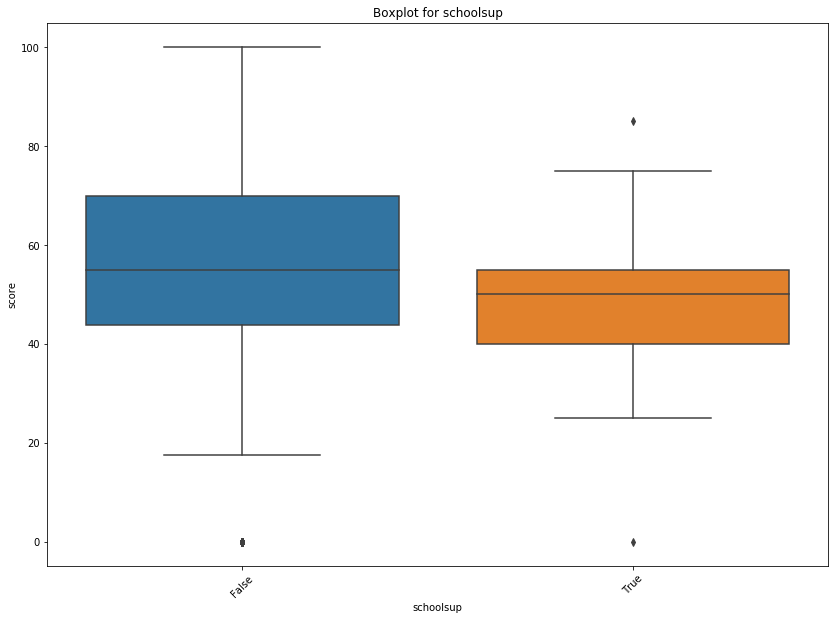

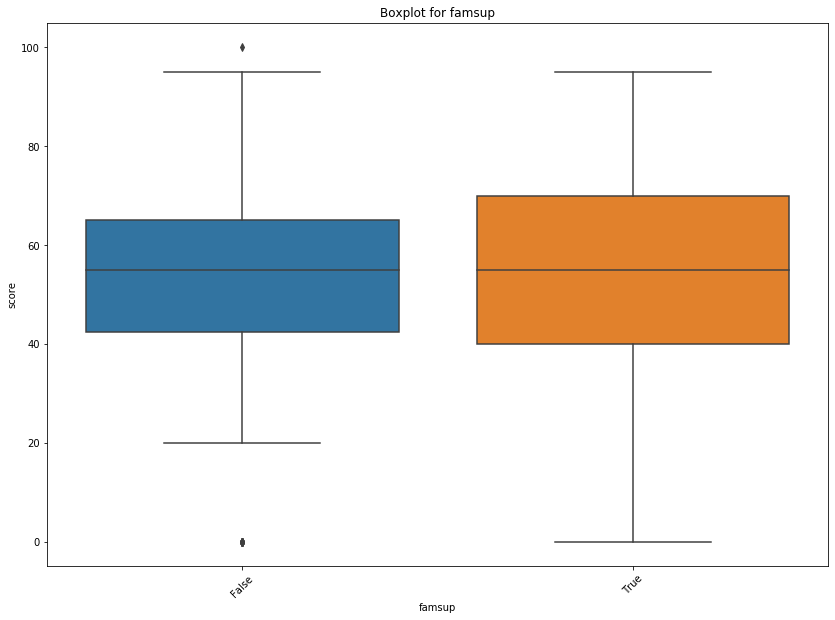

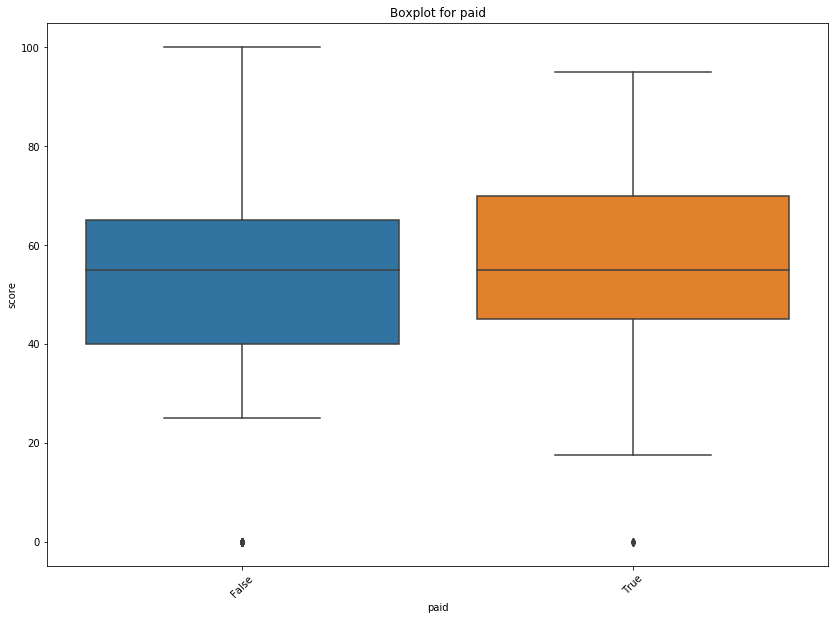

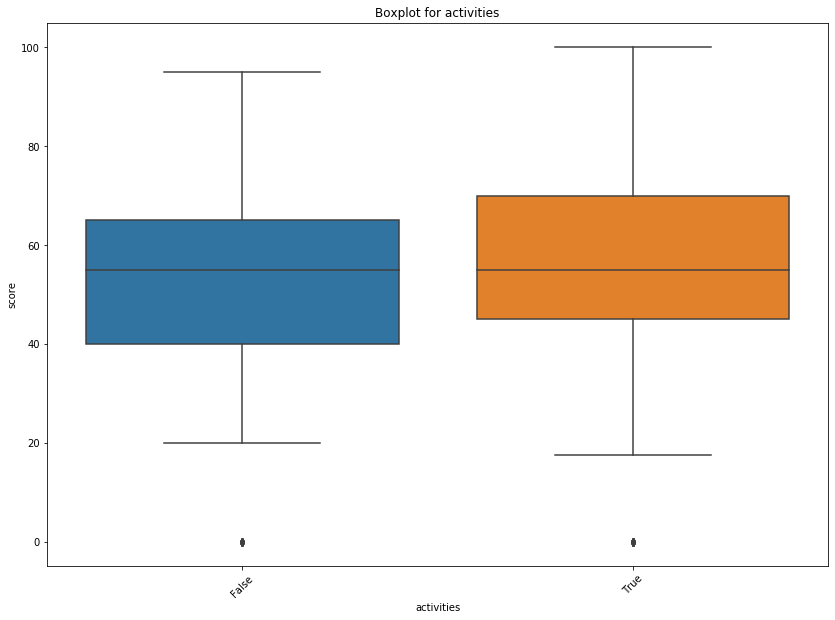

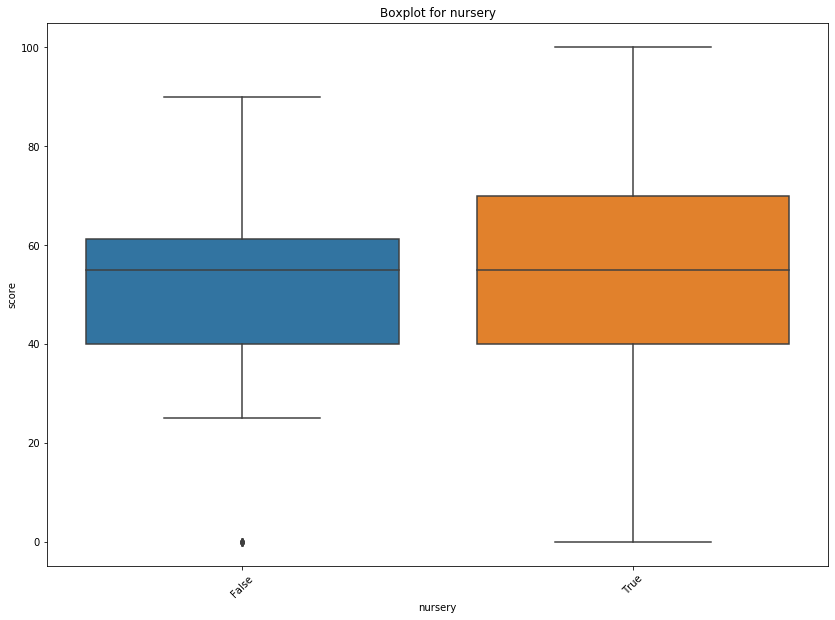

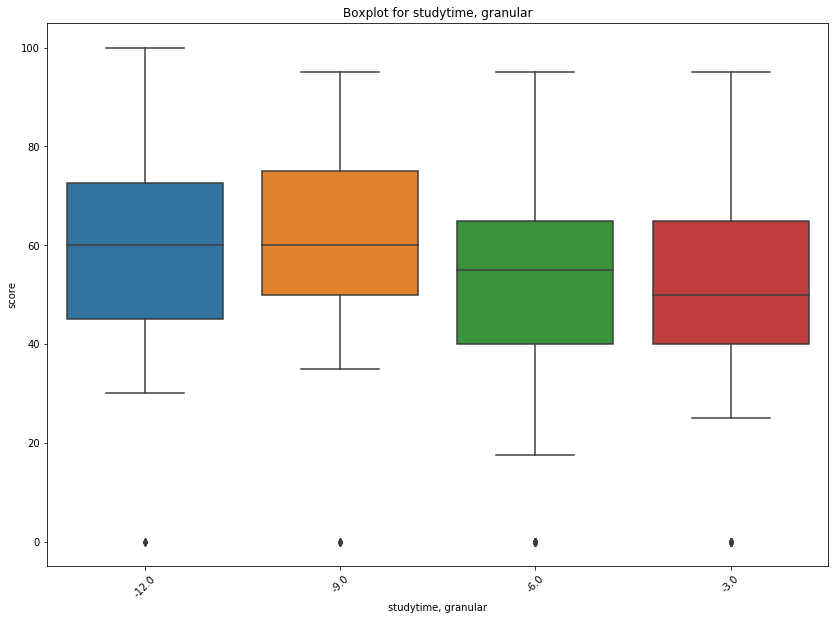

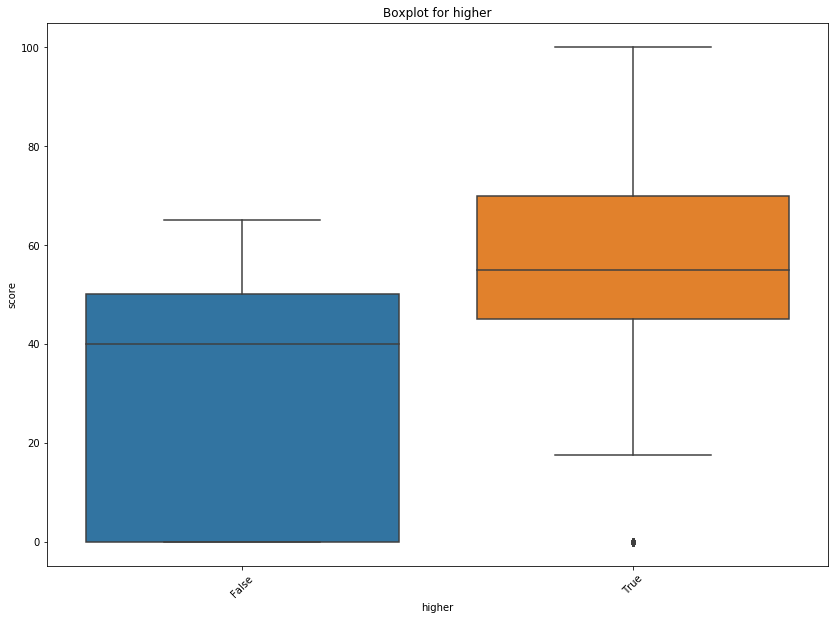

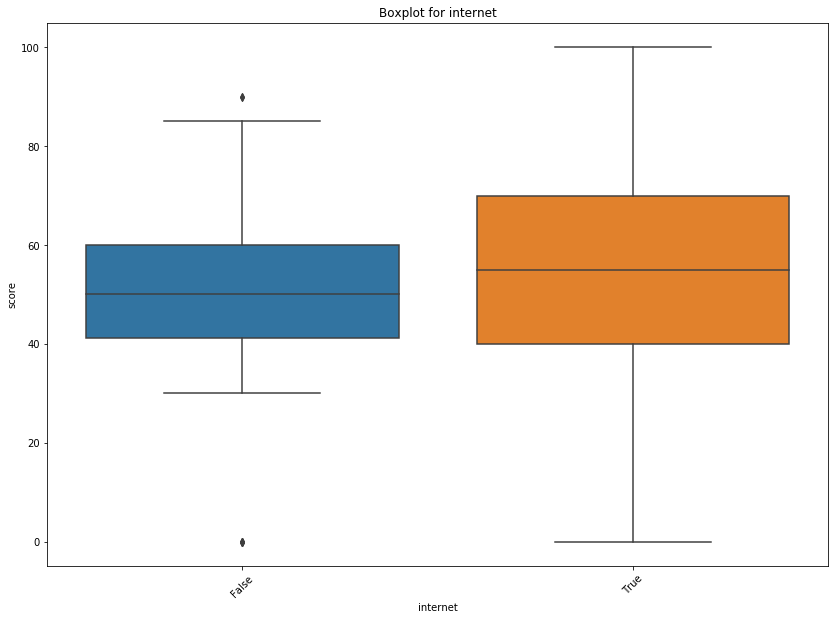

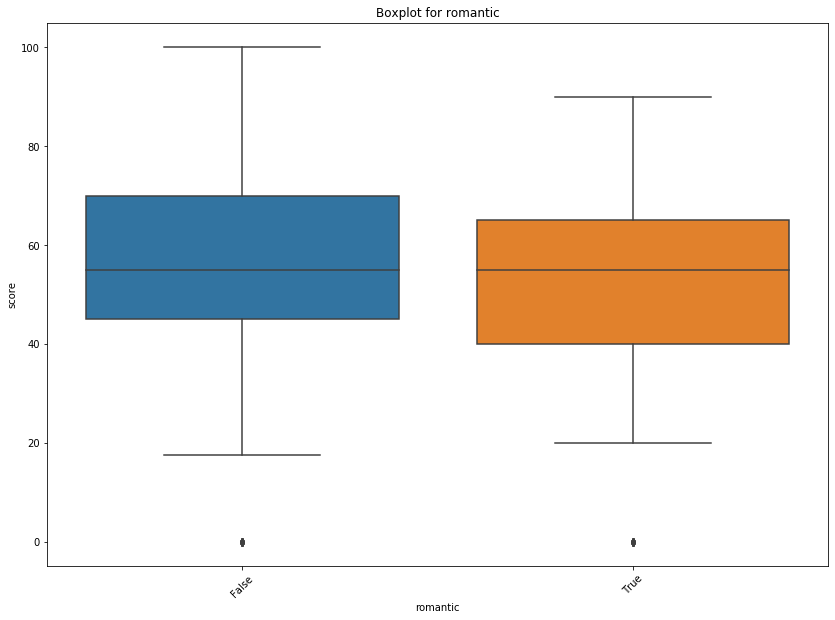

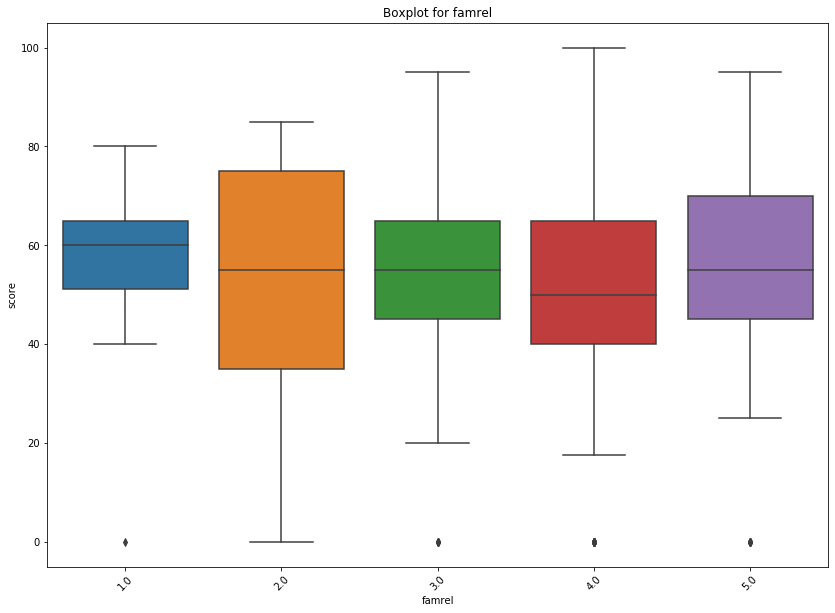

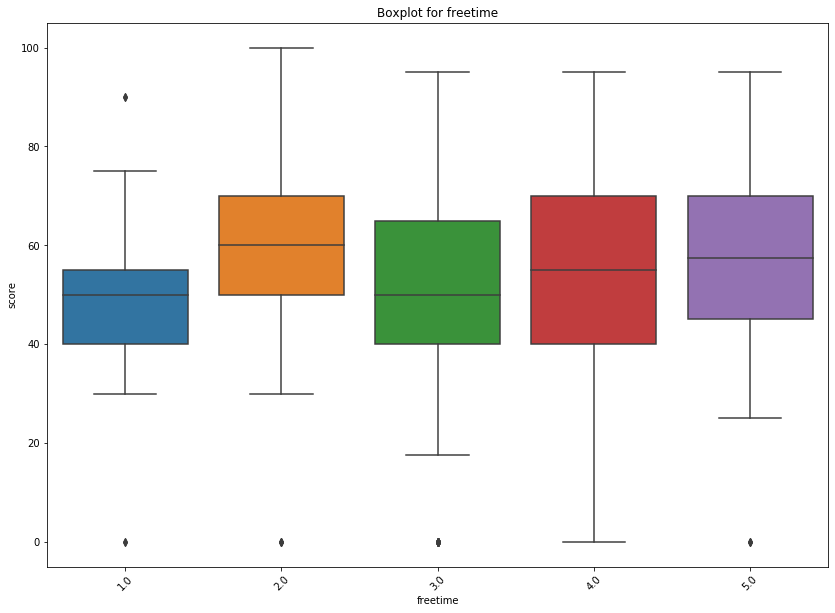

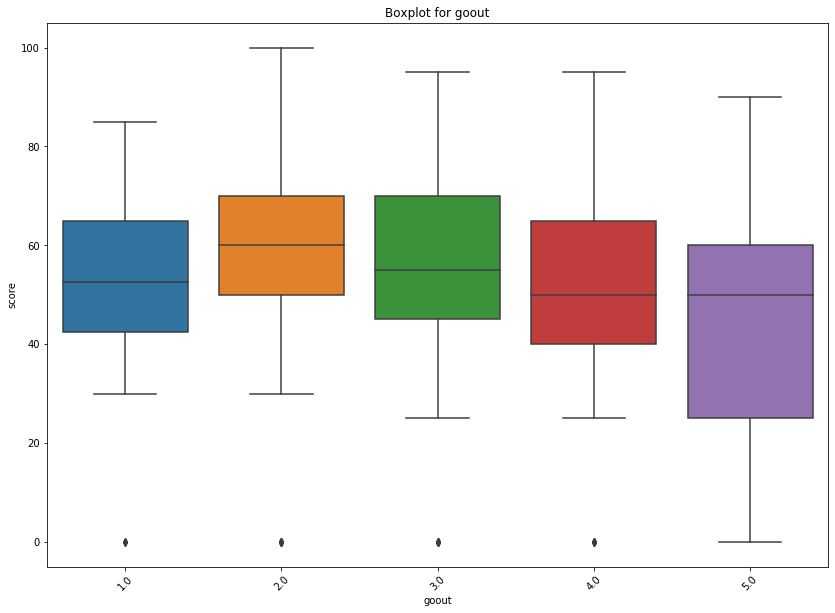

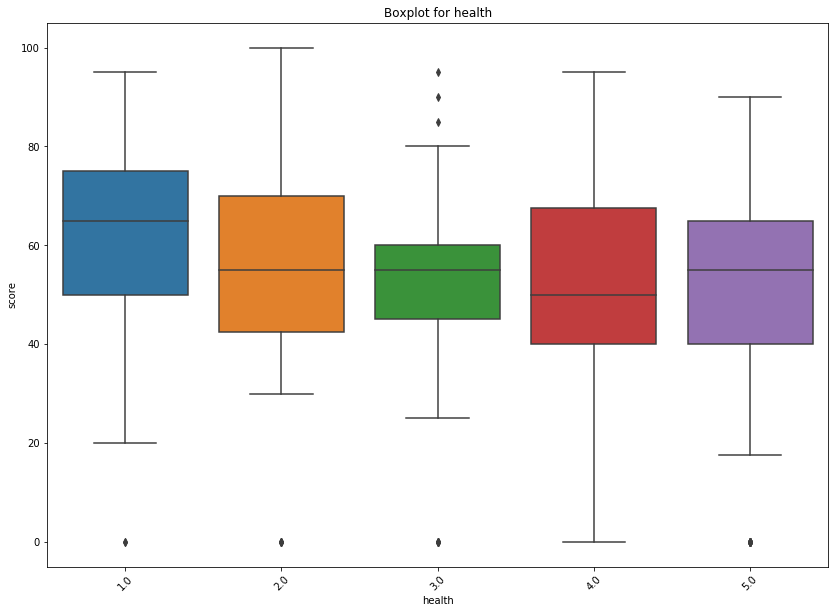

In [117]:
for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health']:
    get_boxplot(col)

,absences,score
absences,1.00000,0.07129
score,0.07129,1.00000


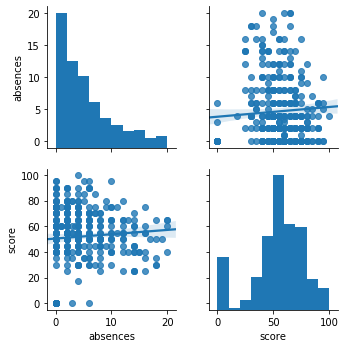

In [128]:
df_cont = df.loc[:,['absences','score']]
df_cont = df_cont[df_cont.absences <= 20]
display(df_cont.corr())
sns.pairplot(df_cont, kind = 'reg')
#если отсекаем по границам выбросов то коэфф. 0.07, если нет - 0.03, 
# параметры abscences и score все ещё скореллированы слабо

In [129]:
df.to_csv('processed\\output.csv') #сохраним заполненный датасет отдельно для дальнейшего использования

## Выводы:

Итак, в результате EDA для анализа влияния различных условий и характеристик жизни ученика на итоговый бал по экзамену по математики были получены следующие выводы:

- В данных достаточно мало пустых значений, все признаки достаточно заполнены, чтобы продолжать с ними работать.
- Выбросы найдены в столбце с количеством прогулов. Найдено несколько несущественных опечаток.
- Параметры Abscences и Score положительно слабоскореллированы. Трудно выявить определенную закономерность. 
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели - это age, address, Medu, Mjob, failures, higher, romantic и goout